# Retinal OCT Imaging
<hr style="border:2px solid pink">

## Introduction

#### Background

Retinal optical coherence tomography (OCT) is a noninvasive imaging technique that essentially takes pictures of your retinas by measuring how much light reflects off the retina and optic nerve. It can be used to diagnose and manage diseases like diabetes-related retinopathy and glaucoma, amongst others. Millions of OCT scans are performed each year, and the analysis and interpretation of the images can take up a tremendous amount of time.

#### Business Problem

In order to save time and resources in analyzing and interpreting OCT scans, the problem at hand is to create a model that can predict whether a patient's retinal scan is normal or shows signs of CNV, DME, or DRUSEN diseases. 

The stakeholders are medical professionals, specifically ophthalmologists.

#### Data Understanding

The data for this project comes from Kaggle: https://www.kaggle.com/datasets/paultimothymooney/kermany2018/data. It
contains 84,495 images, and 4 categories to predict (NORMAL, CNV, DME, or DRUSEN). 

The data is split into separate train, test, and validation folders. Within each of these, there are labeled sub-folders for each category, with each individual image labeled as such: (disease)-(randomized patient ID)-(image number by
this patient).

The images were selected from adult patients from the Shiley Eye Institute of the University of California San Diego, the California Retinal Research Foundation, Medical Center Ophthalmology Associates, the Shanghai First People’s Hospital, and Beijing Tongren Eye Center between July 1, 2013 and March 1, 2017. 

#### Definitions

According to the National Library of Medicine, the following terms are defined as follows: 

1. CNV: (Choroidal Neovascularization): a condition where abnormal blood vessels grow beneath the retina in the choroid area. These abnormal blood vessels can leak fluid or blood into the retina, which can cause vision loss. Commonly associated with age-related macular degeneration (AMD), which is a leading cause of vision loss in older adults.

2. DME (Diabetic Macular Edema): a complication of diabetic retinopathy, which is an eye condition that can develop in people with diabetes. DME occurs when fluid builds in the macula, the central part of the retina responsible for our central vision, leading to to vision impairment and distortion.

3. Drusen: small yellow or white deposits that accumulate in the retina. They can be found in the macula or the peripheral retina. Drusen are a hallmark sign of age-related macular degeneration (AMD). 

Treatment options for CNV, DME, and AMD may include medications, laser therapy, or in some cases, surgical interventions, depending on the specific condition and its stage.
<hr style="border:2px solid pink">

# General Exploration

To get started, let's import the necessary libraries.

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.image import imread
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, StratifiedKFold

from sklearn.metrics import confusion_matrix, classification_report, make_scorer,\
recall_score,accuracy_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay

from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import warnings
warnings.filterwarnings('ignore')

Let's load in the data next. We need to create directories to where the data is saved, so let's start with that. 

In [12]:
# create directory paths for each folder (train, test, and val)
train_path = '../Data/OCT2017/train'
test_path = '../Data/OCT2017/test'
val_path = '../Data/OCT2017/val'

We'll load in the data normally, no scaling or augmentations done, setting smaller batch sizes, and setting seed=42 to help with reproducibility. 

In [13]:
original_train = ImageDataGenerator().flow_from_directory(train_path, batch_size=200, seed=42)
original_test = ImageDataGenerator().flow_from_directory(test_path, batch_size=100, seed=42)
original_val = ImageDataGenerator().flow_from_directory(val_path, batch_size=5, seed=42)

original_train_images, original_train_labels = next(original_train)
original_test_images, original_test_labels = next(original_test)
original_val_images, original_val_labels = next(original_val)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


Notice that there are 4 classes: This represents normal, CNV, DME, or Drusen. Before visualizing the distribution, let's find out the original size of the images. We can loop through every image in the images datasets, take the size of it, add it to a list, and take the unique values of the list to confirm each image is the same size. But first, let's look at the shape as this should tell us the size as well. 

In [14]:
print(f"Train Images Shape: {original_train_images.shape}")
print(f"Train Labels Shape: {original_train_labels.shape}")
print(f"Test Images Shape: {original_test_images.shape}")
print(f"Test Labels Shape: {original_test_labels.shape}")
print(f"Val Images Shape: {original_val_images.shape}")
print(f"Val Labels Shape: {original_val_labels.shape}")

Train Images Shape: (200, 256, 256, 3)
Train Labels Shape: (200, 4)
Test Images Shape: (100, 256, 256, 3)
Test Labels Shape: (100, 4)
Val Images Shape: (5, 256, 256, 3)
Val Labels Shape: (5, 4)


It looks like each image is 256x256, but let's confirm this with the loop.

In [15]:
# loop through each images in the array and add the size to an empty list
train_sizes = []
test_sizes = []
val_sizes = []

for img in original_train_images:
    size = np.array(array_to_img(img).size)
    train_sizes.append(size)
    
for img in original_test_images:
    size = np.array(array_to_img(img).size)
    test_sizes.append(size)
    
for img in original_val_images:
    size = np.array(array_to_img(img).size)
    val_sizes.append(size)

In [16]:
# how many unique sizes are in each list? theoretically should be the same for each pic
# change the list of np arrays into a list of tuples, then take the "set" to get unique values

unique_train_sizes = list(set([tuple(size) for size in train_sizes]))
unique_test_sizes = list(set([tuple(size) for size in test_sizes]))
unique_val_sizes = list(set([tuple(size) for size in val_sizes]))

print(f"Original Train Image Size: {unique_train_sizes}")
print(f"Original Test Image Size: {unique_test_sizes}")
print(f"Original Val Image Size: {unique_val_sizes}")

Original Train Image Size: [(256, 256)]
Original Test Image Size: [(256, 256)]
Original Val Image Size: [(256, 256)]


Great! So the original images were indeed all 256x256. Since I noticed when loading in the data that there are 4 classes, let's now take a look at the distribution of the images in our dataset. 

In [17]:
# first, create paths to each individual folder
normal_train_path = '../Data/OCT2017/train/NORMAL'
cnv_train_path = '../Data/OCT2017/train/CNV'
dme_train_path = '../Data/OCT2017/train/DME'
drusen_train_path = '../Data/OCT2017/train/DRUSEN'

# then, take the "length" of each folder to get the total number of images per category
normal_count = len(os.listdir(normal_train_path))
cnv_count = len(os.listdir(cnv_train_path))
dme_count = len(os.listdir(dme_train_path))
drusen_count = len(os.listdir(drusen_train_path))

# print the results
print(f'Normal Count: {normal_count}')
print(f'CNV Count: {cnv_count}')
print(f'DME Count: {dme_count}')
print(f'Drusen Count: {drusen_count}')

Normal Count: 26315
CNV Count: 37205
DME Count: 11348
Drusen Count: 8616


So, there are 26,315 normal images, 37,205 CNV images, 11,348 DME images, and 8,616 Drusen images. Let's visualize the distribution. 

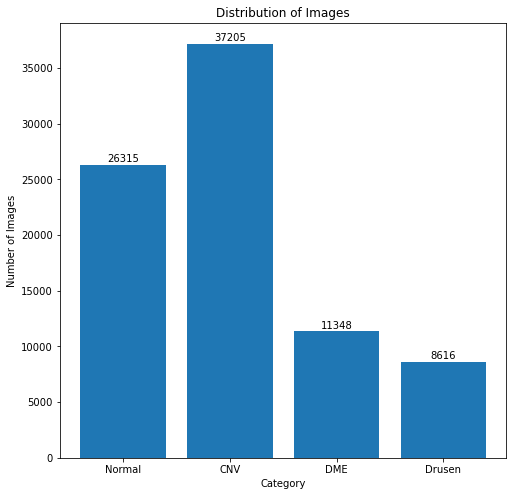

In [18]:
# create the categories for X (categories) and Y (counts)
categories = ['Normal', 'CNV', 'DME', 'Drusen']
counts = [normal_count, cnv_count, dme_count, drusen_count]

# plot it
fig, ax = plt.subplots(figsize=(8,8))
plt.bar(categories, counts)
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Distribution of Images')

# add counts to the top of the bars
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

plt.show();

This makes the distributions a little more clear! There's the most CNV images and the least Drusen images. Another thing to note is that our dataset it imbalanced - it may be beneficial to try data augmentation when modeling.

Let's look at a few images and labels, so we can get an idea of what we're dealing with. 

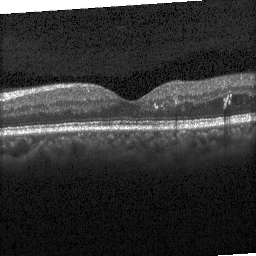

In [19]:
array_to_img(original_train_images[16])

In [20]:
original_train_labels[16]

array([0., 1., 0., 0.], dtype=float32)

In [21]:
original_train.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

Ok, so here, I see that each category corresponds to a class. CNV is class 0, DME is class 1, DRUSEN is class 2, and NORMAL is class 3. 

You would interpret the array [0., 1., 0., 0.] as follows: the first class (index 0, corresponds to CNV) has a probability of 0. The second class (index 1, corresponds to DME) has a probability of 1. The third class (index 2, corresponds to Drusen) and the fourth class (index 3, corresponds to normal) have probabilities of 0. This means that the image falls under class 1, and is DME. 

Let's plot a few images from each class, with their corresponding labels titling the plot.

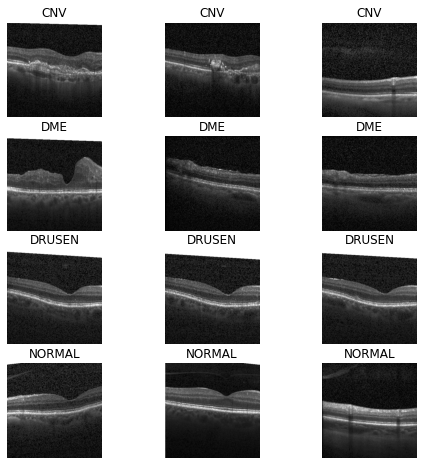

In [22]:
# we have paths to each subfolder, so create a list paths that has them all
# create a list categories with each of the subfolders for labeling purposes
paths = [cnv_train_path, dme_train_path, drusen_train_path, normal_train_path]
categories = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
fig, axes = plt.subplots(nrows=len(categories), ncols=3, figsize=(8, 8))

# iterate through paths to get the image path
for index, path in enumerate(paths):
    image_files = [file for file in os.listdir(path) if file.endswith('.jpeg')]
    
    # Limit the number of images to fit the layout
    total_images_per_cat = min(len(image_files), 3)
    
    for i in range(total_images_per_cat): 
        image_file = image_files[i]
        image_path = os.path.join(path, image_file)
        image = imread(image_path)
        image = image[:400, :400]
            
        # Display the image in a subplot
        ax = axes[index, i]
        ax.imshow(image, cmap='gray')
        ax.set_title(categories[index])  # Display the label
        ax.axis('off')

plt.show()

Great! So we have a little better understanding of what each image might look like. Let's start preprocessing so we can start modeling. 

# Preprocessing

To preprocess the data for a convolutional neural network, I'd like to start the following: 
1. Scale the data: CNNs are sensitive to the scale of input features. By scaling the data, you ensure numerical stability during training. For images, pixel values are usually in the range [0,255], so you can rescale them to the range [0,1] by dividing each pixel by 255.
2. Resize the images: Smaller images can be less computationally intensive, leading to faster training times. This will also help ensure all inputs have the same shape. I will start with decreasing the size to 64x64.
3. Set the seed: To help with reproducibility, I will set the seed equal to 42. 
4. Set the color mode: Since these images are originally in black and white, I will set the color_mode to grayscale to capture this. 
5. Set data augmentation filters: we'll add filters such as flipping, shifting, rotating, and adjusting the brightness/zoom/shearness of the images. This will randomly apply these transformations to the images in order to add more data to the training set only, adding variety into our model and increasing the size of the training set. 

In [23]:
# to remind myself where each path leads
train_path = '../Data/OCT2017/train'
test_path = '../Data/OCT2017/test'
val_path = '../Data/OCT2017/val'

In [ ]:
# giving you the split already
# val set of 32 = last set you test on
# the test gen set, train the model on train split using val split, test it on this as unseen
# ideally after on a good model, train on entire train set, and test on val set
# then test on entire dataset and deploy
# try using 32x32 instead of 64x64, and then bump up as needed if there are decent scores

# add in some flips and rotates, adds x number of images for the model to train on
# dont worry too much about data augmentation and using the validation split in the fit method

In [394]:
# load in and preprocess the data in smaller batches
# Scale and transform the images, reshape to be 64x64, set the seed, and set the color to grayscale

target_size = (64,64)
train_generator = ImageDataGenerator(rescale=1.0/255.0,
                                         horizontal_flip=True,
                                         height_shift_range=0.2,
                                         width_shift_range=0.2,
                                         rotation_range=45,
                                         brightness_range=[0.2,1],
                                         zoom_range=0.2, 
                                         shear_range=0.2
                                         ).flow_from_directory(train_path, 
                                                               target_size=target_size, 
                                                               batch_size=200, 
                                                               seed=42, 
                                                               color_mode='grayscale') 

test_generator = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(test_path, 
                                                                         target_size=target_size, 
                                                                         batch_size=100, 
                                                                         seed=42, 
                                                                         color_mode='grayscale')

val_generator = ImageDataGenerator(rescale=1.0/255.0).flow_from_directory(val_path, 
                                                                        target_size=target_size, 
                                                                        batch_size=5, 
                                                                        seed=42, 
                                                                        color_mode='grayscale')

# next fetches the next batch of data and labels from the generator
# returns a batch of images and their labels
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


Great! Let's check out the following to make sure everything was properly loaded. 
1. Check out the shapes - everything should be rescaled to 64x64. 
2. Check out the images - everything should be in black and white and smaller in size. 

In [318]:
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")
print(f"Val Images Shape: {val_images.shape}")
print(f"Val Labels Shape: {val_labels.shape}")

Train Images Shape: (200, 64, 64, 1)
Train Labels Shape: (200, 4)
Test Images Shape: (100, 64, 64, 1)
Test Labels Shape: (100, 4)
Val Images Shape: (5, 64, 64, 1)
Val Labels Shape: (5, 4)


The shapes all look good! We can see that they are indeed 64x64 for the images, with the color channel as 1, indicating it is grayscale. Next, let's check out a few images. 

In [319]:
train_generator.class_indices

{'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}

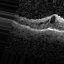

In [320]:
array_to_img(train_images[0])

In [321]:
# second value has probability of 1, so this DME
print(train_labels[0])

[0. 1. 0. 0.]


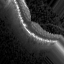

In [322]:
array_to_img(train_images[3])

In [323]:
# last value has probability of 1, so this is normal
print(train_labels[3])

[0. 0. 0. 1.]


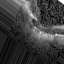

In [324]:
array_to_img(train_images[6])

In [325]:
# first value has probability of 1, so this is CNV
print(train_labels[6])

[1. 0. 0. 0.]


The images look good, they are in black and white, and scaled down to 64x64. 

Let's create some functions to help speed along some of the repetitive steps I will take. 

# Create Functions

Next, let's build some functions next to help speed up viewing the results of each model. 
1. A function that evaluates the model's train and test performance. 
2. A function to plot the loss and accuracy. 
3. A function to plot the confusion matrices. 

Let's start with the evaluate function. We'll print out the loss, accuracy, precision, and recall for both the train and test sets. 

In [107]:
# 1. a function that evaluates the train and test performance of the model
def evaluate_model(model):
    train_results = model.evaluate(train_images, train_labels)
    test_results = model.evaluate(test_images, test_labels)
    
    print(f'Training Loss: {train_results[0]:.3} \nTraining Accuracy: {train_results[1]:.3} \nTraining Precision: {train_results[2]:.3} \nTraining Recall: {train_results[3]:.3}')  
    print('---------------------------')
    print(f'Testing Loss: {test_results[0]:.3} \nTesting Accuracy: {test_results[1]:.3} \nTesting Precision: {test_results[2]:.3} \nTesting Recall: {test_results[3]:.3}')    

Next, let's create a function to plot the loss and accuracy for us. 

In [108]:
# 2. a function to plot the loss and accuracy
def plot_metrics(results):
    train_loss = results.history['loss']
    train_accuracy = results.history['accuracy']

    val_loss = results.history['val_loss']
    val_accuracy = results.history['val_accuracy']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
    sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax2, label='train_accuracy')

    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
    sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax2, label='val_accuracy')
    
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')

    plt.tight_layout()
    plt.show();

Finally, let's create a function to plot the confusion matrix for us.

confusion matrix only plotting for individual batches, can't get it for the test set AFTER the train test split

In [109]:
# 3. a function to plot the confusion matrix
def plot_confusion_matrix(model, test_images, test_labels):
    y_pred = model.predict(test_images)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)

    cm = confusion_matrix(test_labels, y_pred)
    cm_df = pd.DataFrame(cm, index=['CNV', 'DME', 'DRUSEN', 'NORMAL'], columns=['CNV', 'DME', 'DRUSEN', 'NORMAL'])

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

In [110]:
# base = most frequent class - dummy classifier or class distribution
# baseline model = fsm, updates names

# Baseline model

For my baseline model, I will use the class distribution. We created the counts of each disease earlier, let's divide that by the total number of images to get the % distribution. 

In [111]:
# should equal 83,484 as we saw when we loaded in the data using ImageDataGenerator
total = normal_count + cnv_count + dme_count + drusen_count
total

83484

In [112]:
print(f'Normal % Distribution: {round((normal_count/total),2)}')
print(f'CNV % Distribution: {round((cnv_count/total),2)}')
print(f'DME % Distribution: {round((dme_count/total),2)}')
print(f'Drusen % Distribution: {round((drusen_count/total),2)}')

Normal % Distribution: 0.32
CNV % Distribution: 0.45
DME % Distribution: 0.14
Drusen % Distribution: 0.1


# First Simple Model

For my first simple model, I will use a simple convolutional neural network with no hidden convolutional layers. I will begin with a dense input layer, expecting grayscale images of size 64x64x1. The input layer will have 64 units and use the ReLU activation function to introduce non-linearity and capture complex features. Next, I will add a flatten layer to transform the output from the previous layer into a 1D vector, preparing it for the final output layer. The output layer will consist of a dense layer with 4 units to represent the 4 classes, and it will use the softmax activation function, which is a common choice for multi-class classification tasks.

In [326]:
model_1 = Sequential()
model_1.add(Dense(64, activation='relu', input_shape=(64, 64, 1)))
model_1.add(Flatten())
model_1.add(Dense(4, activation='softmax'))

Let's view the architecture of the model. 

In [327]:
model_1.summary()

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_130 (Dense)            (None, 64, 64, 64)        128       
_________________________________________________________________
flatten_42 (Flatten)         (None, 262144)            0         
_________________________________________________________________
dense_131 (Dense)            (None, 4)                 1048580   
Total params: 1,048,708
Trainable params: 1,048,708
Non-trainable params: 0
_________________________________________________________________


So we can see that there are a LOT of parameters for such a simple model! Must be due to the size of the dataset. Let's compile the model using the adam optimizer (Adam is a good starting choice because Adam is an adaptive learning rate optimization algorithm. It should help with a more efficient convergence), categorical crossentropy as the loss (this is an appropriate choice for a multi-class classsification task), and accuracy as the metric. 

In [328]:
precision = Precision()
recall = Recall()

In [329]:
model_1.compile(optimizer='adam',
                loss='categorical_crossentropy', 
                metrics=['accuracy', precision, recall])

Finally, let's fit the model on the train set. I will use the following parameters: 
- Smaller batches of 100, meaning my model will process 100 training samples at a time before adjusting the weights. 
- 25 epochs: epochs specifies how many times the model will iterate over the entire dataset. 
- Validation data: Remember the train test split? I will use the original test_images dataset with 243 images as my validation data in this case, as we have a separate test set from the train test split. 

In [330]:
# set validation split = 25% of data, this is the holdout test set
model_1_results = model_1.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
2/2 [==============================] - 1s 282ms/step - loss: 1.5793 - accuracy: 0.2733 - precision_10: 0.5111 - recall_10: 0.1533 - val_loss: 2.2685 - val_accuracy: 0.3600 - val_precision_10: 0.3659 - val_recall_10: 0.3000
Epoch 2/25
2/2 [==============================] - 0s 50ms/step - loss: 1.8853 - accuracy: 0.4733 - precision_10: 0.4831 - recall_10: 0.3800 - val_loss: 2.0356 - val_accuracy: 0.4000 - val_precision_10: 0.2778 - val_recall_10: 0.2000
Epoch 3/25
2/2 [==============================] - 0s 51ms/step - loss: 1.4103 - accuracy: 0.4400 - precision_10: 0.4674 - recall_10: 0.2867 - val_loss: 1.8428 - val_accuracy: 0.3200 - val_precision_10: 0.1765 - val_recall_10: 0.0600
Epoch 4/25
2/2 [==============================] - 0s 49ms/step - loss: 1.3681 - accuracy: 0.3467 - precision_10: 0.3818 - recall_10: 0.1400 - val_loss: 1.5175 - val_accuracy: 0.3200 - val_precision_10: 0.3333 - val_recall_10: 0.1000
Epoch 5/25
2/2 [==============================] - 0s 50ms/step - lo

Great! Let's evaluate the scores. 

In [331]:
evaluate_model(model_1)

4/4 [==============================] - 0s 27ms/step - loss: 3.4798 - accuracy: 0.2400 - precision_10: 0.2273 - recall_10: 0.2000
Training Loss: 0.824 
Training Accuracy: 0.74 
Training Precision: 0.829 
Training Recall: 0.58
---------------------------
Testing Loss: 3.48 
Testing Accuracy: 0.24 
Testing Precision: 0.227 
Testing Recall: 0.2


UPDATE: This is very overfit! We have a train accuracy of 91% and a test accuracy of 34%. Training recall and precision are pretty high, standing at 97% for precision and 81% for recall, but again, the test scores are abysmal. Test precision stands at 39% and test recall stands at 32%. Let's visualize the loss and accuracy. 

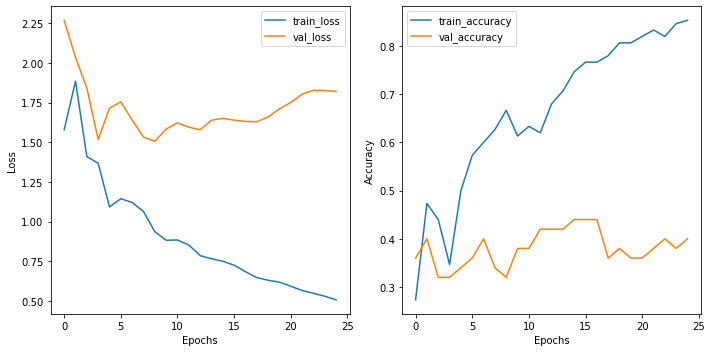

In [332]:
plot_metrics(model_1_results)

UPDATE LATER: 
Here, we can see that the train loss is decreasing, val loss is jumping all over the place, train accuracy is steadily increasing, but val accuracy is low. 

# Test Model

In [365]:
test_model = Sequential()

test_model.add(Conv2D(filters=64, 
                      kernel_size=(3,3), 
                      activation='relu', 
                      input_shape=(64, 64, 1)))

test_model.add(Dense(128, activation='relu'))
test_model.add(Dense(64, activation='relu'))
test_model.add(MaxPooling2D(pool_size=(2,2)))
test_model.add(Dropout(0.2))

test_model.add(Dense(128, activation='relu'))
test_model.add(Dense(64, activation='relu'))
test_model.add(MaxPooling2D(pool_size=(2,2)))
test_model.add(Dropout(0.2))

test_model.add(Dense(128, activation='relu'))
test_model.add(Dense(64, activation='relu'))
test_model.add(MaxPooling2D(pool_size=(2,2)))
test_model.add(Dropout(0.2))

test_model.add(Flatten())
test_model.add(Dense(128, activation='relu'))
test_model.add(Dense(64, activation='relu'))
test_model.add(Dropout(0.3))
test_model.add(Dense(4, activation='softmax'))

test_model.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy',metrics=['accuracy', precision, recall])

test_model.summary()

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_140 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
dense_170 (Dense)            (None, 62, 62, 128)       8320      
_________________________________________________________________
dense_171 (Dense)            (None, 62, 62, 64)        8256      
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_90 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
dense_172 (Dense)            (None, 31, 31, 128)       8320      
_________________________________________________________________
dense_173 (Dense)            (None, 31, 31, 64)      

In [ ]:
# callbacks=early_stop

In [380]:
test_model_results = test_model.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=150, 
                              epochs=10, 
                              class_weight=class_weights_dict)

Epoch 1/10
1/1 [==============================] - 0s 129ms/step - loss: 1.3606 - accuracy: 0.3933 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - val_loss: 1.3853 - val_accuracy: 0.3400 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 113ms/step - loss: 1.3617 - accuracy: 0.3467 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - val_loss: 1.3852 - val_accuracy: 0.3400 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 0s 108ms/step - loss: 1.3611 - accuracy: 0.3733 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - val_loss: 1.3852 - val_accuracy: 0.3400 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 0s 106ms/step - loss: 1.3616 - accuracy: 0.4400 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - val_loss: 1.3852 - val_accuracy: 0.3400 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00


In [381]:
evaluate_model(test_model)

4/4 [==============================] - 0s 37ms/step - loss: 1.3860 - accuracy: 0.2200 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00
Training Loss: 1.38 
Training Accuracy: 0.44 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.39 
Testing Accuracy: 0.22 
Testing Precision: 0.0 
Testing Recall: 0.0


In [237]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)

In [248]:
y_ints = [y.argmax() for y in train_labels]
class_weights = compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_ints),
                                                  y=y_ints)

# turn into dict so it can be put in the fit statement
class_weights_dict = {class_index: weight for class_index, weight in enumerate(class_weights)}

In [249]:
class_weights_dict

{0: 0.5376344086021505,
 1: 1.7241379310344827,
 2: 2.7777777777777777,
 3: 0.8333333333333334}

In [382]:
test_2 = Sequential()
test_2.add(Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 1)))
test_2.add(MaxPooling2D(pool_size=(2, 2)))
test_2.add(Dropout(0.2))
test_2.add(Dense(128, activation='relu'))

test_2.add(Flatten())
# test_2.add(Dense(128, activation='relu'))
# test_2.add(Dropout(0.2))
test_2.add(Dense(64, activation='relu'))
test_2.add(Dense(32, activation='relu'))
test_2.add(Dense(4, activation='softmax'))

test_2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy', precision, recall])

test_2.summary()

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_144 (Conv2D)          (None, 62, 62, 64)        640       
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_98 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
dense_192 (Dense)            (None, 31, 31, 128)       8320      
_________________________________________________________________
flatten_57 (Flatten)         (None, 123008)            0         
_________________________________________________________________
dense_193 (Dense)            (None, 64)                7872576   
_________________________________________________________________
dense_194 (Dense)            (None, 32)              

In [383]:
test_2_results = test_2.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=150, 
                              epochs=50, 
                              class_weight=class_weights_dict, 
                              callbacks=early_stop)

Epoch 1/50
1/1 [==============================] - 0s 411ms/step - loss: 1.3624 - accuracy: 0.1800 - precision_10: 0.0000e+00 - recall_10: 0.0000e+00 - val_loss: 1.4162 - val_accuracy: 0.4000 - val_precision_10: 0.3125 - val_recall_10: 0.1000
Epoch 2/50
1/1 [==============================] - 0s 51ms/step - loss: 1.4226 - accuracy: 0.4867 - precision_10: 0.6094 - recall_10: 0.2600 - val_loss: 2.1676 - val_accuracy: 0.1600 - val_precision_10: 0.1667 - val_recall_10: 0.1000
Epoch 3/50
1/1 [==============================] - 0s 51ms/step - loss: 1.8708 - accuracy: 0.1400 - precision_10: 0.1509 - recall_10: 0.1067 - val_loss: 1.6108 - val_accuracy: 0.1600 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 4/50
1/1 [==============================] - 0s 50ms/step - loss: 1.4186 - accuracy: 0.1400 - precision_10: 0.1304 - recall_10: 0.0200 - val_loss: 1.3503 - val_accuracy: 0.3400 - val_precision_10: 0.0000e+00 - val_recall_10: 0.0000e+00
Epoch 5/50
1/1 [===========================

In [384]:
evaluate_model(test_2)

4/4 [==============================] - 0s 14ms/step - loss: 1.4812 - accuracy: 0.2200 - precision_10: 0.1765 - recall_10: 0.0300
Training Loss: 1.27 
Training Accuracy: 0.46 
Training Precision: 0.706 
Training Recall: 0.06
---------------------------
Testing Loss: 1.48 
Testing Accuracy: 0.22 
Testing Precision: 0.176 
Testing Recall: 0.03


# Model #2

My first simple model was very overfit, let's try making it more complex and adding some hidden layers. Will add convolutional and max pooling. 

In [56]:
model_2 = Sequential()

model_2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(64, 64, 1)))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2,2)))

model_2.add(Flatten())
model_2.add(Dense(4, activation='softmax'))

model_2.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy', precision, recall])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 50180     
Total params: 68,996
Trainable params: 68,996
Non-trainable params: 0
__________________________________________________

A lot less params. 

In [149]:
model_2_results = model_2.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25)

Epoch 1/25
2/2 [==============================] - 0s 73ms/step - loss: 0.7121 - accuracy: 0.7400 - precision: 0.8571 - recall: 0.6000 - val_loss: 1.2390 - val_accuracy: 0.5000 - val_precision: 0.6957 - val_recall: 0.3200
Epoch 2/25
2/2 [==============================] - 0s 54ms/step - loss: 0.6860 - accuracy: 0.7467 - precision: 0.8774 - recall: 0.6200 - val_loss: 1.2544 - val_accuracy: 0.5200 - val_precision: 0.6296 - val_recall: 0.3400
Epoch 3/25
2/2 [==============================] - 0s 57ms/step - loss: 0.6505 - accuracy: 0.7667 - precision: 0.8889 - recall: 0.6400 - val_loss: 1.2950 - val_accuracy: 0.4600 - val_precision: 0.5517 - val_recall: 0.3200
Epoch 4/25
2/2 [==============================] - 0s 55ms/step - loss: 0.6264 - accuracy: 0.8133 - precision: 0.9174 - recall: 0.6667 - val_loss: 1.3245 - val_accuracy: 0.4600 - val_precision: 0.5333 - val_recall: 0.3200
Epoch 5/25
2/2 [==============================] - 0s 57ms/step - loss: 0.5881 - accuracy: 0.8067 - precision: 0.8966

In [150]:
evaluate_model(model_2)

4/4 [==============================] - 0s 14ms/step - loss: 4.7955 - accuracy: 0.2600 - precision: 0.2778 - recall: 0.2500
Training Loss: 0.644 
Training Accuracy: 0.84 
Training Precision: 0.849 
Training Recall: 0.79
---------------------------
Testing Loss: 4.8 
Testing Accuracy: 0.26 
Testing Precision: 0.278 
Testing Recall: 0.25


UPDATE: A little bit better - train accuracy at 77%, precision at 86%, recall at 65%. Testing accuracy is higher at 44%, precision at 43%, and recall at 30%. 

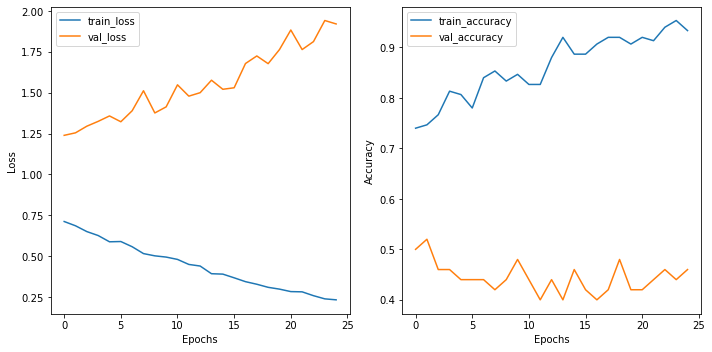

In [151]:
plot_metrics(model_2_results)

# Model #3

Let's add more complexity - more conv and 2d layers, add some dense layers, and add dense layer after flatten. 

In [63]:
model_3 = Sequential()

model_3.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(64, 64, 1)))
model_3.add(MaxPooling2D(pool_size=(2,2)))

model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))

model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))

model_3.add(Flatten())
model_3.add(Dense(32, activation='relu'))
model_3.add(Dense(16, activation='relu'))
model_3.add(Dense(4, activation='softmax'))

model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

model_3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 32)        18464     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1152)             

More params than first model, less than baseline. Fit the model. 

In [ ]:
# dont do train test split
# train on entirety of train data
# use val data as pre given test data
# validation data = the test set

# research how batch size in image data generator affects batch size - how affects .fit on model
# epochs makes a difference

In [64]:
model_3_results = model_3.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              validation_data=(test_images, test_labels))

Epoch 1/25
2/2 [==============================] - 0s 230ms/step - loss: 1.3870 - accuracy: 0.1333 - precision: 0.2500 - recall: 0.0840 - val_loss: 1.3728 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 0s 61ms/step - loss: 1.3641 - accuracy: 0.4867 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3460 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 0s 60ms/step - loss: 1.3341 - accuracy: 0.4867 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3154 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 0s 59ms/step - loss: 1.2800 - accuracy: 0.4867 - precision: 0.3333 - recall: 0.0200 - val_loss: 1.3045 - val_accuracy: 0.4000 - val_precision: 0.5217 - val_recall: 0.2400
Epoch 5/25
2/2 [==============================] - 0s 55ms/step - loss: 1.25

In [ ]:
# not complex enough
# feature engineering!! add data (image augmentation)
# start simply (binary) either has it or it doesn't, then think about the mutliclass

In [65]:
evaluate_model(model_3)

4/4 [==============================] - 0s 9ms/step - loss: 1.9708 - accuracy: 0.2900 - precision: 0.2308 - recall: 0.1200
Training Loss: 1.12 
Training Accuracy: 0.515 
Training Precision: 0.657 
Training Recall: 0.345
---------------------------
Testing Loss: 1.97 
Testing Accuracy: 0.29 
Testing Precision: 0.231 
Testing Recall: 0.12


Worse all around

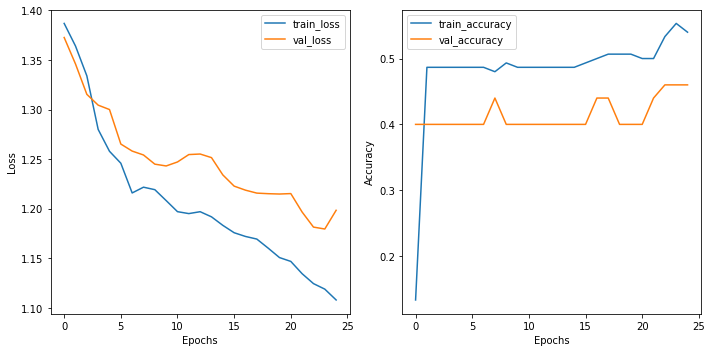

In [66]:
plot_metrics(model_3_results)

Let's try increasing the input units. Same model as second model otherwise. 

# Model #4

In [67]:
model_4 = Sequential()

model_4.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(64, 64, 1)))
model_4.add(MaxPooling2D(pool_size=(2,2)))

model_4.add(Conv2D(128, (3, 3), activation='relu')) # increased from 64 to 128
model_4.add(MaxPooling2D(pool_size=(2,2)))

model_4.add(Conv2D(64, (3, 3), activation='relu')) # increased from 32 to 64
model_4.add(MaxPooling2D(pool_size=(2,2)))

model_4.add(Flatten())
model_4.add(Dense(64, activation='relu')) # increased from 32 to 64
model_4.add(Dense(32, activation='relu')) # increased from 16 to 32
model_4.add(Dense(4, activation='softmax'))

model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

model_4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2304)             

More params!

In [68]:
model_4_results = model_4.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              validation_data=(test_images, test_labels))

Epoch 1/25
2/2 [==============================] - 1s 259ms/step - loss: 1.3827 - accuracy: 0.2733 - precision: 0.2308 - recall: 0.0480 - val_loss: 1.3576 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 0s 86ms/step - loss: 1.3461 - accuracy: 0.4867 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3024 - val_accuracy: 0.4000 - val_precision: 0.6667 - val_recall: 0.0400
Epoch 3/25
2/2 [==============================] - 0s 82ms/step - loss: 1.2638 - accuracy: 0.4867 - precision: 0.5217 - recall: 0.0800 - val_loss: 1.3288 - val_accuracy: 0.4000 - val_precision: 0.4545 - val_recall: 0.3000
Epoch 4/25
2/2 [==============================] - 0s 80ms/step - loss: 1.2785 - accuracy: 0.4867 - precision: 0.5000 - recall: 0.3533 - val_loss: 1.2674 - val_accuracy: 0.4000 - val_precision: 0.5238 - val_recall: 0.2200
Epoch 5/25
2/2 [==============================] - 0s 77ms/step - loss: 1.2249 - accuracy: 0.4867 - 

In [69]:
evaluate_model(model_4)

4/4 [==============================] - 0s 12ms/step - loss: 2.1485 - accuracy: 0.2800 - precision: 0.3239 - recall: 0.2300
Training Loss: 1.07 
Training Accuracy: 0.57 
Training Precision: 0.694 
Training Recall: 0.34
---------------------------
Testing Loss: 2.15 
Testing Accuracy: 0.28 
Testing Precision: 0.324 
Testing Recall: 0.23


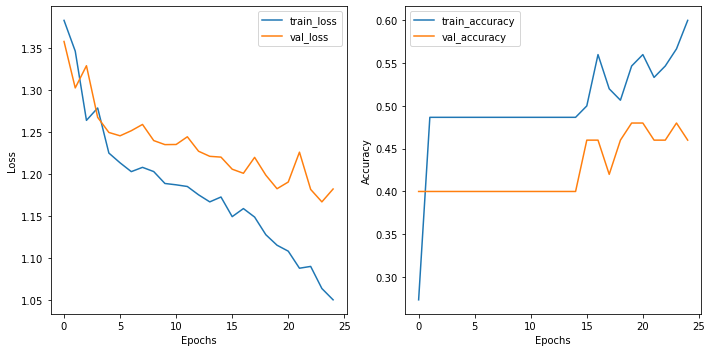

In [70]:
plot_metrics(model_4_results)

Performed about the same as second model. 

Let's try adding regularization. 

# Model #5

Add regulurization, start with just L2. 

In [71]:
model_5 = Sequential()

model_5.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1), 
                        kernel_regularizer=l2(0.01)))

model_5.add(MaxPooling2D(pool_size=(2,2)))

model_5.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_5.add(MaxPooling2D(pool_size=(2,2)))

model_5.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_5.add(MaxPooling2D(pool_size=(2,2)))

model_5.add(Flatten())
model_5.add(Dense(64, activation='relu'))
model_5.add(Dense(32, activation='relu'))
model_5.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.01)))

model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

model_5.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 12, 64)        73792     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 2304)             

In [72]:
model_5_results = model_5.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              validation_data=(test_images, test_labels))

Epoch 1/25
2/2 [==============================] - 1s 266ms/step - loss: 2.8172 - accuracy: 0.3467 - precision: 0.3239 - recall: 0.0920 - val_loss: 2.6703 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 0s 78ms/step - loss: 2.6239 - accuracy: 0.4867 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.5001 - val_accuracy: 0.4000 - val_precision: 0.6000 - val_recall: 0.1200
Epoch 3/25
2/2 [==============================] - 0s 92ms/step - loss: 2.4520 - accuracy: 0.4867 - precision: 0.4808 - recall: 0.1667 - val_loss: 2.4462 - val_accuracy: 0.4000 - val_precision: 0.4412 - val_recall: 0.3000
Epoch 4/25
2/2 [==============================] - 0s 83ms/step - loss: 2.3694 - accuracy: 0.4867 - precision: 0.5045 - recall: 0.3733 - val_loss: 2.2990 - val_accuracy: 0.4000 - val_precision: 0.4783 - val_recall: 0.2200
Epoch 5/25
2/2 [==============================] - 0s 90ms/step - loss: 2.2451 - accuracy: 0.4867 - 

In [73]:
evaluate_model(model_5)

4/4 [==============================] - 0s 13ms/step - loss: 1.9471 - accuracy: 0.2700 - precision: 0.2800 - recall: 0.1400
Training Loss: 1.32 
Training Accuracy: 0.52 
Training Precision: 0.676 
Training Recall: 0.25
---------------------------
Testing Loss: 1.95 
Testing Accuracy: 0.27 
Testing Precision: 0.28 
Testing Recall: 0.14


About the same. 

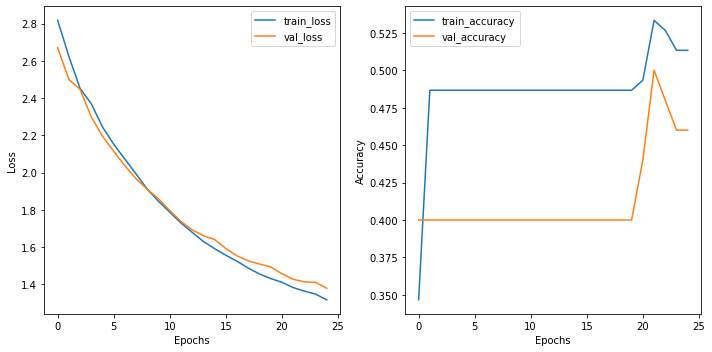

In [74]:
plot_metrics(model_5_results)

Let's try adding dropout regularization. 

# Model #6

In [75]:
model_6 = Sequential()

model_6.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1), 
                        kernel_regularizer=l2(0.01)))

model_6.add(MaxPooling2D(pool_size=(2,2)))
model_6.add(Dropout(0.8))

model_6.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_6.add(MaxPooling2D(pool_size=(2,2)))
model_6.add(Dropout(0.5))

model_6.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_6.add(MaxPooling2D(pool_size=(2,2)))
model_6.add(Dropout(0.2))

model_6.add(Flatten())
model_6.add(Dense(64, activation='relu'))
model_6.add(Dense(32, activation='relu'))
model_6.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.01)))

model_6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

model_6.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 29, 29, 128)       36992     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 12, 12, 64)       

In [76]:
model_6_results = model_6.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              validation_data=(test_images, test_labels))

Epoch 1/25
2/2 [==============================] - 1s 284ms/step - loss: 2.8472 - accuracy: 0.3333 - precision: 0.2745 - recall: 0.0560 - val_loss: 2.7589 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 1s 273ms/step - loss: 2.6709 - accuracy: 0.4867 - precision: 0.3333 - recall: 0.0333 - val_loss: 2.6608 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 1s 411ms/step - loss: 2.5401 - accuracy: 0.4933 - precision: 0.4483 - recall: 0.0867 - val_loss: 2.5686 - val_accuracy: 0.3600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 1s 495ms/step - loss: 2.4786 - accuracy: 0.4467 - precision: 0.3810 - recall: 0.0533 - val_loss: 2.4767 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 1s 309ms/step - loss: 2.3807 -

In [77]:
evaluate_model(model_6)

4/4 [==============================] - 0s 35ms/step - loss: 1.8550 - accuracy: 0.2600 - precision: 0.2222 - recall: 0.0200
Training Loss: 1.56 
Training Accuracy: 0.52 
Training Precision: 0.875 
Training Recall: 0.035
---------------------------
Testing Loss: 1.85 
Testing Accuracy: 0.26 
Testing Precision: 0.222 
Testing Recall: 0.02


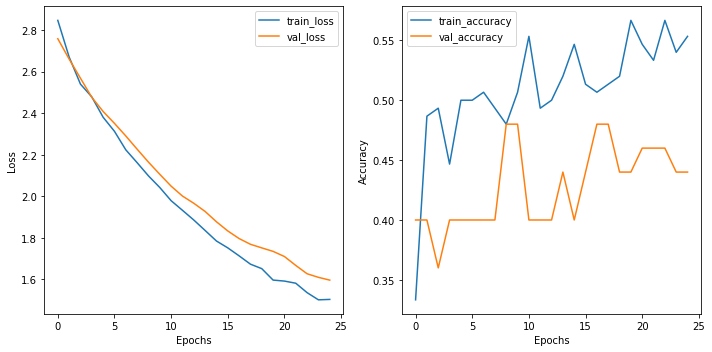

In [78]:
plot_metrics(model_6_results)

# Model #6

Let's try adding dense hidden layers. 

In [79]:
model_7 = Sequential()

model_7.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1), 
                        kernel_regularizer=l2(0.01)))

model_7.add(Dense(128, activation='relu'))
model_7.add(MaxPooling2D(pool_size=(2,2)))
model_7.add(Dropout(0.8))

model_7.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_7.add(Dense(64, activation='relu'))
model_7.add(MaxPooling2D(pool_size=(2,2)))
model_7.add(Dropout(0.5))

model_7.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_7.add(Dense(32, activation='relu'))
model_7.add(MaxPooling2D(pool_size=(2,2)))
model_7.add(Dropout(0.2))

model_7.add(Flatten())
model_7.add(Dense(64, activation='relu'))
model_7.add(Dense(32, activation='relu'))
model_7.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.01)))

model_7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

model_7.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
dense_19 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 29, 29, 128)       147584    
_________________________________________________________________
dense_20 (Dense)             (None, 29, 29, 64)        8256      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 14, 14, 64)       

That added more params, let's check it out. 

In [80]:
model_7_results = model_7.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              validation_data=(test_images, test_labels))

Epoch 1/25
2/2 [==============================] - 3s 1s/step - loss: 3.3418 - accuracy: 0.3867 - precision: 0.2222 - recall: 0.0080 - val_loss: 3.1941 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 1s 710ms/step - loss: 3.1068 - accuracy: 0.4867 - precision: 0.4783 - recall: 0.0733 - val_loss: 3.0034 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 1s 685ms/step - loss: 2.9132 - accuracy: 0.4867 - precision: 0.4861 - recall: 0.2333 - val_loss: 2.8531 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 1s 552ms/step - loss: 2.7537 - accuracy: 0.4867 - precision: 0.5111 - recall: 0.1533 - val_loss: 2.7121 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 1s 632ms/step - loss: 2.5983 - ac

In [81]:
evaluate_model(model_7)

4/4 [==============================] - 0s 76ms/step - loss: 1.7386 - accuracy: 0.2800 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.44 
Training Accuracy: 0.49 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.74 
Testing Accuracy: 0.28 
Testing Precision: 0.0 
Testing Recall: 0.0


The loss looks better but the accuracy! still terrible ugh.

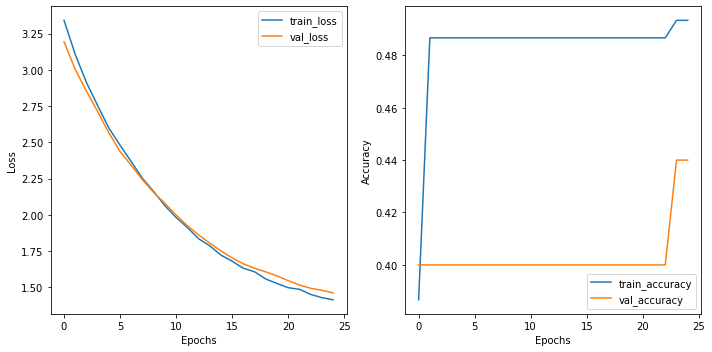

In [82]:
plot_metrics(model_7_results)

# Model #8

Not really getting better results yet, still overfit and not performing that well. Let's try adding early stopping to help with the overfitting. 

In [83]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5)

In [85]:
model_8 = Sequential()

model_8.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1), 
                        kernel_regularizer=l2(0.01)))

model_8.add(Dense(128, activation='relu'))
model_8.add(MaxPooling2D(pool_size=(2,2)))
model_8.add(Dropout(0.8))

model_8.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_8.add(Dense(64, activation='relu'))
model_8.add(MaxPooling2D(pool_size=(2,2)))
model_8.add(Dropout(0.5))

model_8.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_8.add(Dense(32, activation='relu'))
model_8.add(MaxPooling2D(pool_size=(2,2)))
model_8.add(Dropout(0.2))

model_8.add(Flatten())
model_8.add(Dense(64, activation='relu'))
model_8.add(Dense(32, activation='relu'))
model_8.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.01)))

model_8.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

model_8.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
dense_31 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 29, 29, 128)       147584    
_________________________________________________________________
dense_32 (Dense)             (None, 29, 29, 64)        8256      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 14, 14, 64)      

In [86]:
model_8_results = model_8.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              validation_data=(test_images, test_labels))

Epoch 1/25
2/2 [==============================] - 2s 1s/step - loss: 3.3472 - accuracy: 0.1800 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 3.1853 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 1s 656ms/step - loss: 3.1333 - accuracy: 0.4867 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.9978 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 1s 679ms/step - loss: 2.9160 - accuracy: 0.4867 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.8043 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 1s 563ms/step - loss: 2.7010 - accuracy: 0.4867 - precision: 0.4474 - recall: 0.1133 - val_loss: 2.6325 - val_accuracy: 0.4000 - val_precision: 0.6250 - val_recall: 0.1000
Epoch 5/25
2/2 [==============================] - 1s 530ms/step - l

In [87]:
evaluate_model(model_8)

4/4 [==============================] - 0s 110ms/step - loss: 1.8138 - accuracy: 0.2200 - precision: 0.1538 - recall: 0.0200
Training Loss: 1.38 
Training Accuracy: 0.465 
Training Precision: 0.577 
Training Recall: 0.075
---------------------------
Testing Loss: 1.81 
Testing Accuracy: 0.22 
Testing Precision: 0.154 
Testing Recall: 0.02


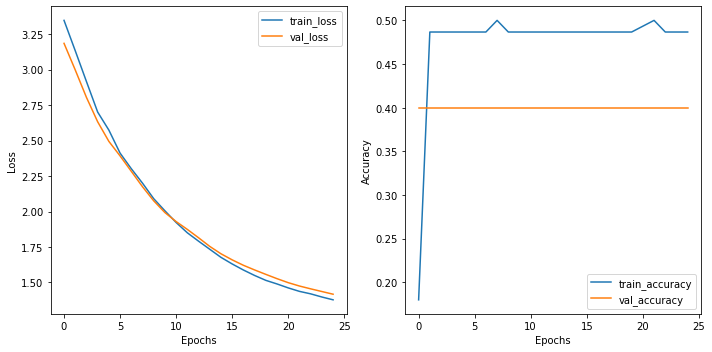

In [88]:
plot_metrics(model_8_results)

# Model #9

Maybe my model is too complex, let's try reducing some layers and see if that helps performance. 

In [90]:
model_9 = Sequential()

model_9.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1), 
                        kernel_regularizer=l2(0.01)))

model_9.add(Dense(128, activation='relu'))
model_9.add(MaxPooling2D(pool_size=(2,2)))
model_9.add(Dropout(0.8))

model_9.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)))
model_9.add(Dense(64, activation='relu'))
model_9.add(MaxPooling2D(pool_size=(2,2)))
model_9.add(Dropout(0.5))

model_9.add(Flatten())
model_9.add(Dense(64, activation='relu'))
model_9.add(Dense(32, activation='relu'))
model_9.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.01)))

model_9.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

model_9.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
dense_42 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 29, 29, 128)       147584    
_________________________________________________________________
dense_43 (Dense)             (None, 29, 29, 64)        8256      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 14, 14, 64)      

More params!

In [91]:
model_9_results = model_9.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              validation_data=(test_images, test_labels))

Epoch 1/25
2/2 [==============================] - 1s 414ms/step - loss: 2.7097 - accuracy: 0.3000 - precision: 0.1538 - recall: 0.0080 - val_loss: 2.5553 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 0s 241ms/step - loss: 2.4460 - accuracy: 0.4867 - precision: 0.6098 - recall: 0.1667 - val_loss: 2.3651 - val_accuracy: 0.4000 - val_precision: 0.6667 - val_recall: 0.0800
Epoch 3/25
2/2 [==============================] - 0s 242ms/step - loss: 2.3530 - accuracy: 0.4867 - precision: 0.5000 - recall: 0.4067 - val_loss: 2.2869 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 0s 245ms/step - loss: 2.1990 - accuracy: 0.4867 - precision: 0.5294 - recall: 0.1200 - val_loss: 2.2287 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 1s 405ms/step - loss: 2.1220 - accurac

In [92]:
evaluate_model(model_9)

4/4 [==============================] - 0s 67ms/step - loss: 2.0821 - accuracy: 0.2500 - precision: 0.2222 - recall: 0.1800
Training Loss: 1.21 
Training Accuracy: 0.535 
Training Precision: 0.695 
Training Recall: 0.285
---------------------------
Testing Loss: 2.08 
Testing Accuracy: 0.25 
Testing Precision: 0.222 
Testing Recall: 0.18


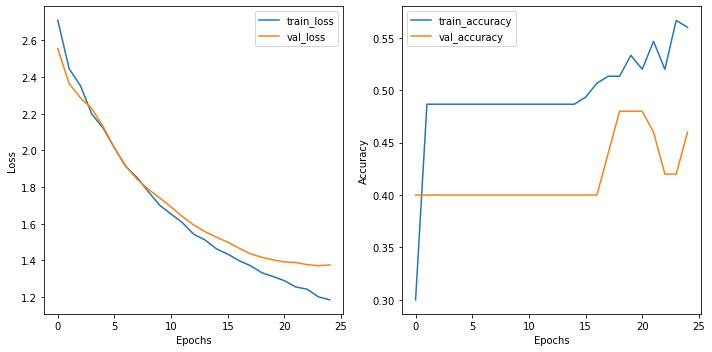

In [93]:
plot_metrics(model_9_results)

# Model #10

Let's try reducing regulurization strength. 

In [94]:
model_10 = Sequential()

model_10.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1), 
                        kernel_regularizer=l2(0.0001)))

model_10.add(Dense(128, activation='relu'))
model_10.add(MaxPooling2D(pool_size=(2,2)))
model_10.add(Dropout(0.8))

model_10.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
model_10.add(Dense(64, activation='relu'))
model_10.add(MaxPooling2D(pool_size=(2,2)))
model_10.add(Dropout(0.5))

model_10.add(Flatten())
model_10.add(Dense(64, activation='relu'))
model_10.add(Dense(32, activation='relu'))
model_10.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.0001)))

model_10.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

model_10.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
dense_47 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 29, 29, 128)       147584    
_________________________________________________________________
dense_48 (Dense)             (None, 29, 29, 64)        8256      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 14, 14, 64)      

In [95]:
model_10_results = model_10.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              validation_data=(test_images, test_labels))

Epoch 1/25
2/2 [==============================] - 2s 1s/step - loss: 1.3876 - accuracy: 0.3067 - precision: 0.2222 - recall: 0.0720 - val_loss: 1.3590 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 1s 630ms/step - loss: 1.2997 - accuracy: 0.4867 - precision: 0.4857 - recall: 0.1133 - val_loss: 1.3078 - val_accuracy: 0.4000 - val_precision: 0.6667 - val_recall: 0.0400
Epoch 3/25
2/2 [==============================] - 1s 557ms/step - loss: 1.2804 - accuracy: 0.4867 - precision: 0.5200 - recall: 0.3467 - val_loss: 1.3077 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 1s 570ms/step - loss: 1.2394 - accuracy: 0.4867 - precision: 0.4878 - recall: 0.1333 - val_loss: 1.3060 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 1s 535ms/step - loss: 1.2283 - accuracy: 

In [96]:
evaluate_model(model_10)

4/4 [==============================] - 0s 70ms/step - loss: 1.7353 - accuracy: 0.2300 - precision: 0.2041 - recall: 0.1000
Training Loss: 1.08 
Training Accuracy: 0.565 
Training Precision: 0.721 
Training Recall: 0.22
---------------------------
Testing Loss: 1.74 
Testing Accuracy: 0.23 
Testing Precision: 0.204 
Testing Recall: 0.1


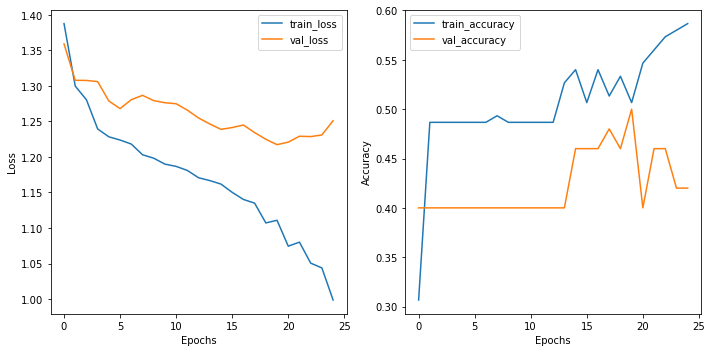

In [97]:
plot_metrics(model_10_results)

# Model #11

Let's add batch normalization.

In [98]:
model_11 = Sequential()

model_11.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1), 
                        kernel_regularizer=l2(0.0001)))
model_11.add(BatchNormalization())
model_11.add(Dense(128, activation='relu'))
model_11.add(MaxPooling2D(pool_size=(2,2)))
model_11.add(Dropout(0.8))

model_11.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.0001)))
model_11.add(BatchNormalization())
model_11.add(Dense(64, activation='relu'))
model_11.add(MaxPooling2D(pool_size=(2,2)))
model_11.add(Dropout(0.5))

model_11.add(Flatten())
model_11.add(Dense(64, activation='relu'))
model_11.add(Dense(32, activation='relu'))
model_11.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.0001)))

model_11.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

model_11.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
dense_52 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 29, 29, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 29, 29, 128)     

In [99]:
model_11_results = model_11.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              validation_data=(test_images, test_labels))

Epoch 1/25
2/2 [==============================] - 3s 2s/step - loss: 5.1596 - accuracy: 0.2600 - precision: 0.2686 - recall: 0.1880 - val_loss: 1.3906 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 2s 831ms/step - loss: 3.2161 - accuracy: 0.3800 - precision: 0.3800 - recall: 0.3800 - val_loss: 1.3980 - val_accuracy: 0.3400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 1s 685ms/step - loss: 3.1013 - accuracy: 0.2200 - precision: 0.2188 - recall: 0.1867 - val_loss: 1.3971 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 1s 633ms/step - loss: 1.4831 - accuracy: 0.3600 - precision: 0.4306 - recall: 0.2067 - val_loss: 1.3936 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 1s 725ms/step - loss: 1.4038 - ac

In [100]:
evaluate_model(model_11)

4/4 [==============================] - 0s 70ms/step - loss: 1.4243 - accuracy: 0.2200 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.35 
Training Accuracy: 0.465 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.42 
Testing Accuracy: 0.22 
Testing Precision: 0.0 
Testing Recall: 0.0


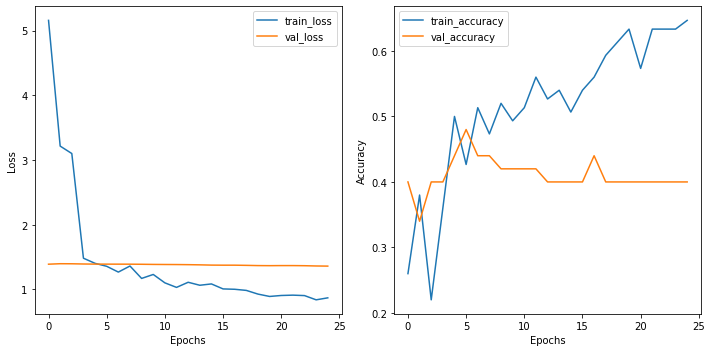

In [101]:
plot_metrics(model_11_results)

# Model #12

Scores are worse all around, but not overfit. Let's try reducing regularization, see if that helps. 

In [103]:
# removed l2, decreasing dropout

model_12 = Sequential()

model_12.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1)))

model_12.add(BatchNormalization())
model_12.add(Dense(128, activation='relu'))
model_12.add(MaxPooling2D(pool_size=(2,2)))
model_12.add(Dropout(0.5))

model_12.add(Conv2D(128, (3, 3), activation='relu'))
model_12.add(BatchNormalization())
model_12.add(Dense(64, activation='relu'))
model_12.add(MaxPooling2D(pool_size=(2,2)))
model_12.add(Dropout(0.2))

model_12.add(Flatten())
model_12.add(Dense(64, activation='relu'))
model_12.add(Dense(32, activation='relu'))
model_12.add(Dense(4, activation='softmax'))

model_12.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

model_12.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
dense_62 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 29, 29, 128)       147584    
_________________________________________________________________
batch_normalization_5 (Batch (None, 29, 29, 128)     

In [104]:
model_12_results = model_12.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              validation_data=(test_images, test_labels))

Epoch 1/25
2/2 [==============================] - 3s 2s/step - loss: 4.3217 - accuracy: 0.2067 - precision: 0.3117 - recall: 0.0960 - val_loss: 1.3676 - val_accuracy: 0.3400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 2s 842ms/step - loss: 3.7996 - accuracy: 0.2867 - precision: 0.2857 - recall: 0.2533 - val_loss: 1.3807 - val_accuracy: 0.3800 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 1s 657ms/step - loss: 2.6017 - accuracy: 0.3533 - precision: 0.3562 - recall: 0.3467 - val_loss: 1.3823 - val_accuracy: 0.3600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 1s 643ms/step - loss: 1.9887 - accuracy: 0.4933 - precision: 0.5036 - recall: 0.4667 - val_loss: 1.3819 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 1s 672ms/step - loss: 1.8745 - ac

In [106]:
evaluate_model(model_12)

4/4 [==============================] - 0s 79ms/step - loss: 1.4293 - accuracy: 0.2200 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.33 
Training Accuracy: 0.465 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.43 
Testing Accuracy: 0.22 
Testing Precision: 0.0 
Testing Recall: 0.0


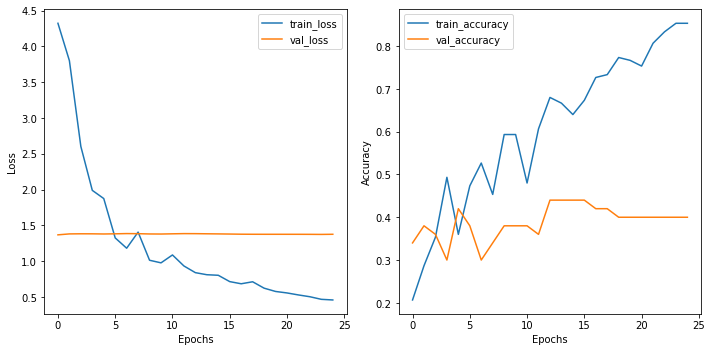

In [107]:
plot_metrics(model_12_results)

# Model #13

Scores were more consistent the last round, still very low. Precision and recall were shot. Let's try reducing the hidden layers. 

In [108]:
model_13 = Sequential()

model_13.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1)))

model_13.add(BatchNormalization())
model_13.add(Dense(128, activation='relu'))
model_13.add(MaxPooling2D(pool_size=(2,2)))
model_13.add(Dropout(0.5))

model_13.add(Flatten())
model_13.add(Dense(64, activation='relu'))
model_13.add(Dense(32, activation='relu'))
model_13.add(Dense(4, activation='softmax'))

model_13.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

model_13.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
dense_67 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 123008)            0         
_________________________________________________________________
dense_68 (Dense)             (None, 64)              

In [109]:
model_13_results = model_13.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              validation_data=(test_images, test_labels))

Epoch 1/25
2/2 [==============================] - 1s 731ms/step - loss: 3.7644 - accuracy: 0.1600 - precision: 0.3276 - recall: 0.0760 - val_loss: 1.3733 - val_accuracy: 0.4000 - val_precision: 0.6000 - val_recall: 0.0600
Epoch 2/25
2/2 [==============================] - 1s 329ms/step - loss: 8.8524 - accuracy: 0.4867 - precision: 0.4867 - recall: 0.4867 - val_loss: 1.4007 - val_accuracy: 0.1000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 1s 380ms/step - loss: 4.1221 - accuracy: 0.3267 - precision: 0.3311 - recall: 0.3267 - val_loss: 1.3549 - val_accuracy: 0.3400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 1s 323ms/step - loss: 1.3185 - accuracy: 0.4400 - precision: 0.4421 - recall: 0.2800 - val_loss: 1.3452 - val_accuracy: 0.4400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 1s 341ms/step - loss: 1.4808 - accurac

In [110]:
evaluate_model(model_13)

4/4 [==============================] - 0s 37ms/step - loss: 1.4052 - accuracy: 0.2000 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.31 
Training Accuracy: 0.57 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.41 
Testing Accuracy: 0.2 
Testing Precision: 0.0 
Testing Recall: 0.0


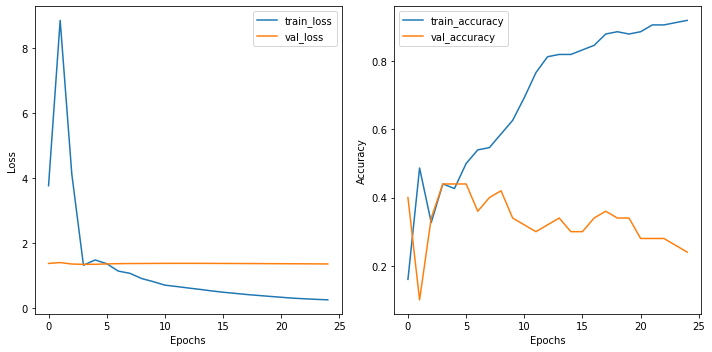

In [111]:
plot_metrics(model_13_results)

Test score is still low, let's add regularization back in. 

# Model #14

In [112]:
model_14 = Sequential()

model_14.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1),
                        kernel_regularizer=l2(0.00001)))

model_14.add(BatchNormalization())
model_14.add(Dense(128, activation='relu'))
model_14.add(MaxPooling2D(pool_size=(2,2)))
model_14.add(Dropout(0.5))

model_14.add(Flatten())
model_14.add(Dense(64, activation='relu'))
model_14.add(Dense(32, activation='relu'))
model_14.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.00001)))

model_14.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

model_14.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
dense_71 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 123008)            0         
_________________________________________________________________
dense_72 (Dense)             (None, 64)              

In [113]:
model_14_results = model_14.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              validation_data=(test_images, test_labels))

Epoch 1/25
2/2 [==============================] - 1s 356ms/step - loss: 2.8179 - accuracy: 0.3133 - precision: 0.5577 - recall: 0.1160 - val_loss: 1.3337 - val_accuracy: 0.3400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 0s 168ms/step - loss: 3.6086 - accuracy: 0.3333 - precision: 0.3333 - recall: 0.3333 - val_loss: 1.3330 - val_accuracy: 0.3600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 0s 155ms/step - loss: 2.0712 - accuracy: 0.4333 - precision: 0.4420 - recall: 0.4067 - val_loss: 1.3679 - val_accuracy: 0.3000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 0s 162ms/step - loss: 1.6158 - accuracy: 0.4867 - precision: 0.4945 - recall: 0.3000 - val_loss: 1.3699 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 0s 159ms/step - loss: 1.0129 -

In [114]:
evaluate_model(model_14)

4/4 [==============================] - 0s 27ms/step - loss: 1.4066 - accuracy: 0.2200 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.27 
Training Accuracy: 0.735 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.41 
Testing Accuracy: 0.22 
Testing Precision: 0.0 
Testing Recall: 0.0


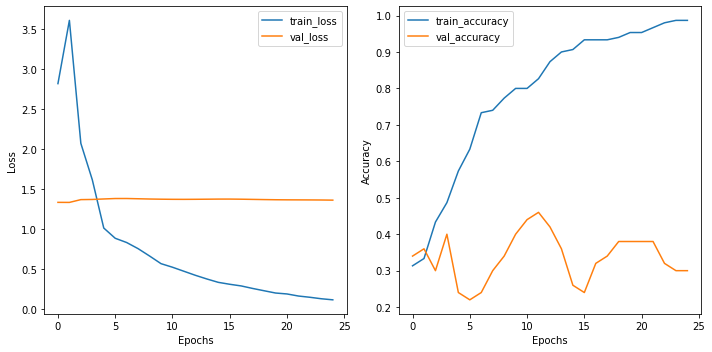

In [115]:
plot_metrics(model_14_results)

# Model #15

Let's add learning rate.

In [116]:
model_15 = Sequential()

model_15.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1),
                        kernel_regularizer=l2(0.00001)))

model_15.add(BatchNormalization())
model_15.add(Dense(128, activation='relu'))
model_15.add(MaxPooling2D(pool_size=(2,2)))
model_15.add(Dropout(0.5))

model_15.add(Flatten())
model_15.add(Dense(64, activation='relu'))
model_15.add(Dense(32, activation='relu'))
model_15.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.00001)))

model_15.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

model_15.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
dense_75 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 123008)            0         
_________________________________________________________________
dense_76 (Dense)             (None, 64)              

In [117]:
model_15_results = model_15.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              validation_data=(test_images, test_labels))

Epoch 1/25
2/2 [==============================] - 1s 330ms/step - loss: 2.2543 - accuracy: 0.2867 - precision: 0.3793 - recall: 0.0880 - val_loss: 1.2674 - val_accuracy: 0.4000 - val_precision: 1.0000 - val_recall: 0.0400
Epoch 2/25
2/2 [==============================] - 0s 154ms/step - loss: 3.1408 - accuracy: 0.4867 - precision: 0.4867 - recall: 0.4867 - val_loss: 1.3863 - val_accuracy: 0.3400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 0s 165ms/step - loss: 1.8393 - accuracy: 0.3267 - precision: 0.3435 - recall: 0.3000 - val_loss: 1.3492 - val_accuracy: 0.3400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 0s 163ms/step - loss: 1.2763 - accuracy: 0.5333 - precision: 0.5429 - recall: 0.5067 - val_loss: 1.3509 - val_accuracy: 0.4400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 0s 166ms/step - loss: 1.0750 - accurac

In [118]:
evaluate_model(model_15)

4/4 [==============================] - 0s 23ms/step - loss: 1.5151 - accuracy: 0.2000 - precision: 0.3333 - recall: 0.0100  
Training Loss: 1.21 
Training Accuracy: 0.7 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.52 
Testing Accuracy: 0.2 
Testing Precision: 0.333 
Testing Recall: 0.01


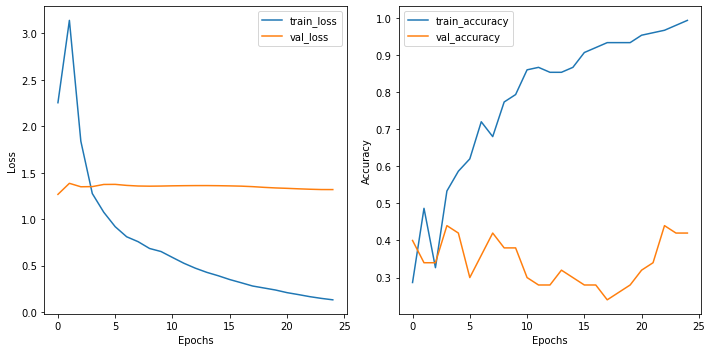

In [119]:
plot_metrics(model_15_results)

# Model #16

Let's change to tanh

In [120]:
model_16 = Sequential()

model_16.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='tanh', 
                        input_shape=(64, 64, 1),
                        kernel_regularizer=l2(0.00001)))

model_16.add(BatchNormalization())
model_16.add(Dense(128, activation='tanh'))
model_16.add(MaxPooling2D(pool_size=(2,2)))
model_16.add(Dropout(0.5))

model_16.add(Flatten())
model_16.add(Dense(64, activation='tanh'))
model_16.add(Dense(32, activation='tanh'))
model_16.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.00001)))

model_16.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

model_16.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_9 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
dense_79 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 123008)            0         
_________________________________________________________________
dense_80 (Dense)             (None, 64)              

In [121]:
model_16_results = model_16.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              validation_data=(test_images, test_labels))

Epoch 1/25
2/2 [==============================] - 2s 1s/step - loss: 1.5679 - accuracy: 0.3533 - precision: 0.4394 - recall: 0.1160 - val_loss: 4.0914 - val_accuracy: 0.1200 - val_precision: 0.1277 - val_recall: 0.1200
Epoch 2/25
2/2 [==============================] - 1s 392ms/step - loss: 1.5194 - accuracy: 0.5000 - precision: 0.5103 - recall: 0.4933 - val_loss: 3.2691 - val_accuracy: 0.1800 - val_precision: 0.1875 - val_recall: 0.1800
Epoch 3/25
2/2 [==============================] - 1s 456ms/step - loss: 1.3444 - accuracy: 0.5733 - precision: 0.5846 - recall: 0.5067 - val_loss: 2.6583 - val_accuracy: 0.2400 - val_precision: 0.2449 - val_recall: 0.2400
Epoch 4/25
2/2 [==============================] - 1s 449ms/step - loss: 1.2209 - accuracy: 0.5933 - precision: 0.6348 - recall: 0.4867 - val_loss: 2.3864 - val_accuracy: 0.3000 - val_precision: 0.3061 - val_recall: 0.3000
Epoch 5/25
2/2 [==============================] - 1s 408ms/step - loss: 1.1388 - accuracy: 0.6600 - precision: 0.69

In [122]:
evaluate_model(model_16)

4/4 [==============================] - 0s 34ms/step - loss: 1.9012 - accuracy: 0.2300 - precision: 0.2024 - recall: 0.1700
Training Loss: 1.31 
Training Accuracy: 0.455 
Training Precision: 0.503 
Training Recall: 0.395
---------------------------
Testing Loss: 1.9 
Testing Accuracy: 0.23 
Testing Precision: 0.202 
Testing Recall: 0.17


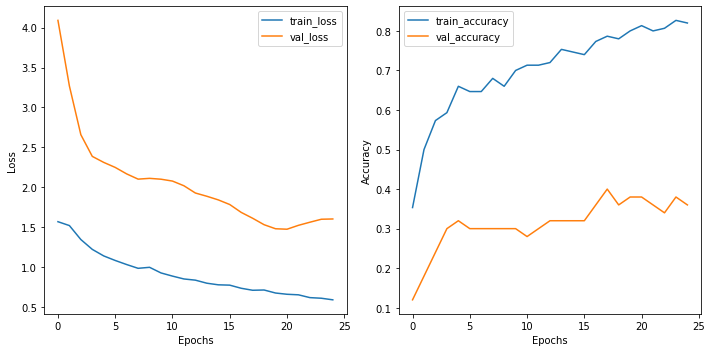

In [123]:
plot_metrics(model_16_results)

# Model #17

We have an imbalanced dataset, nothing above seems to be helping, let's try adjusting the class weights. 

In [187]:
y_ints = [y.argmax() for y in train_labels]
class_weights = compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_ints),
                                                  y=y_ints)

# turn into dict so it can be put in the fit statement
class_weights_dict = {class_index: weight for class_index, weight in enumerate(class_weights)}

In [125]:
model_17 = Sequential()

model_17.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1),
                        kernel_regularizer=l2(0.00001)))

model_17.add(BatchNormalization())
model_17.add(Dense(128, activation='relu'))
model_17.add(MaxPooling2D(pool_size=(2,2)))
model_17.add(Dropout(0.5))

model_17.add(Flatten())
model_17.add(Dense(64, activation='relu'))
model_17.add(Dense(32, activation='relu'))
model_17.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.00001)))

model_17.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

model_17.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_10 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
dense_83 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 123008)            0         
_________________________________________________________________
dense_84 (Dense)             (None, 64)              

In [126]:
model_17_results = model_17.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              validation_data=(test_images, test_labels))

Epoch 1/25
2/2 [==============================] - 1s 327ms/step - loss: 2.7034 - accuracy: 0.2400 - precision: 0.3139 - recall: 0.1720 - val_loss: 1.3478 - val_accuracy: 0.3600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 0s 154ms/step - loss: 1.6287 - accuracy: 0.4000 - precision: 0.3966 - recall: 0.3067 - val_loss: 1.3171 - val_accuracy: 0.4600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 0s 163ms/step - loss: 3.6916 - accuracy: 0.4533 - precision: 0.4533 - recall: 0.4533 - val_loss: 1.3133 - val_accuracy: 0.3400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 0s 164ms/step - loss: 2.3370 - accuracy: 0.3133 - precision: 0.3151 - recall: 0.3067 - val_loss: 1.3213 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 0s 156ms/step - loss: 1.5915 -

In [127]:
evaluate_model(model_17)

4/4 [==============================] - 0s 39ms/step - loss: 1.4183 - accuracy: 0.2400 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.29 
Training Accuracy: 0.78 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.42 
Testing Accuracy: 0.24 
Testing Precision: 0.0 
Testing Recall: 0.0


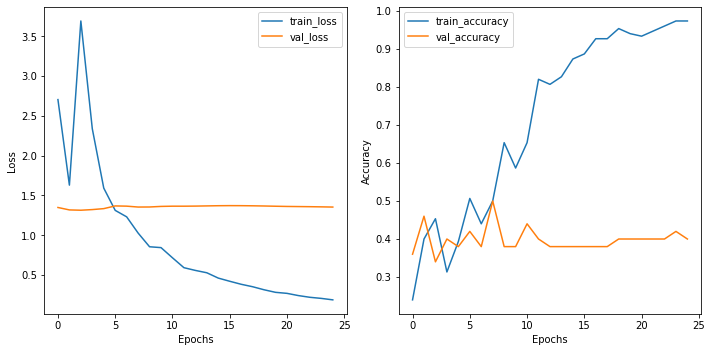

In [128]:
plot_metrics(model_17_results)

# Model #18

In [129]:
model_18 = Sequential()

model_18.add(Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(64, 64, 1),
                        kernel_regularizer=l2(0.00001)))

model_18.add(BatchNormalization())
model_18.add(Dense(128, activation='relu'))
model_18.add(MaxPooling2D(pool_size=(2,2)))
model_18.add(Dropout(0.5))

model_18.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_18.add(BatchNormalization())
model_18.add(Dense(128, activation='relu'))
model_18.add(MaxPooling2D(pool_size=(2,2)))
model_18.add(Dropout(0.5))

model_18.add(Flatten())
model_18.add(Dense(64, activation='relu'))
model_18.add(Dense(32, activation='relu'))
model_18.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.00001)))

model_18.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

model_18.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_11 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
dense_87 (Dense)             (None, 62, 62, 128)       4224      
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 29, 29, 32)        36896     
_________________________________________________________________
batch_normalization_12 (Batc (None, 29, 29, 32)      

In [131]:
model_18_results = model_18.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              validation_data=(test_images, test_labels))

Epoch 1/25
2/2 [==============================] - 2s 1s/step - loss: 2.5144 - accuracy: 0.3933 - precision: 0.5146 - recall: 0.3520 - val_loss: 1.3559 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 1s 528ms/step - loss: 8.1056 - accuracy: 0.4867 - precision: 0.4867 - recall: 0.4867 - val_loss: 1.3765 - val_accuracy: 0.4400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 1s 460ms/step - loss: 1.9506 - accuracy: 0.3667 - precision: 0.3603 - recall: 0.3267 - val_loss: 1.3831 - val_accuracy: 0.3400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 1s 466ms/step - loss: 1.7514 - accuracy: 0.3200 - precision: 0.3274 - recall: 0.2467 - val_loss: 1.3807 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 1s 489ms/step - loss: 1.3117 - ac

In [132]:
evaluate_model(model_18)

4/4 [==============================] - 0s 57ms/step - loss: 1.4006 - accuracy: 0.2200 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.31 
Training Accuracy: 0.465 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.4 
Testing Accuracy: 0.22 
Testing Precision: 0.0 
Testing Recall: 0.0


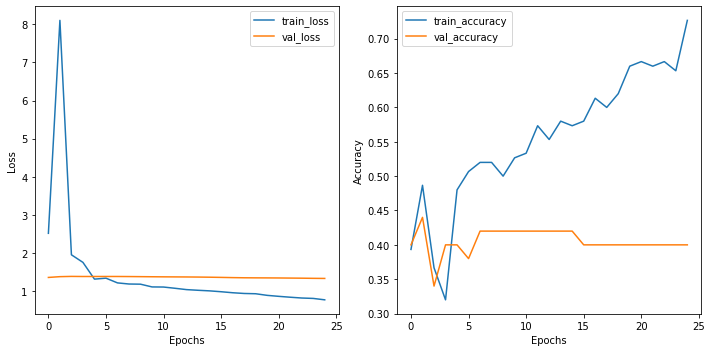

In [133]:
plot_metrics(model_18_results)

# Model #19

In [134]:
model_19 = Sequential()

model_19.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(64, 64, 1)))
model_19.add(BatchNormalization())
model_19.add(Dense(64, activation='relu'))
model_19.add(MaxPooling2D(pool_size=(2,2)))
model_19.add(Dropout(0.3))

model_19.add(Flatten())
model_19.add(Dense(32, activation='relu'))
model_19.add(Dense(16, activation='relu'))
model_19.add(Dense(4, activation='softmax'))

model_19.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

model_19.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_13 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
dense_92 (Dense)             (None, 62, 62, 64)        2112      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 61504)             0         
_________________________________________________________________
dense_93 (Dense)             (None, 32)              

In [135]:
model_19_results = model_19.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              validation_data=(test_images, test_labels))

Epoch 1/25
2/2 [==============================] - 1s 273ms/step - loss: 2.5138 - accuracy: 0.2733 - precision: 0.2600 - recall: 0.0520 - val_loss: 1.3720 - val_accuracy: 0.2400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 0s 98ms/step - loss: 2.4284 - accuracy: 0.4600 - precision: 0.4621 - recall: 0.4467 - val_loss: 1.3581 - val_accuracy: 0.4600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 0s 102ms/step - loss: 1.8346 - accuracy: 0.4867 - precision: 0.4930 - recall: 0.4667 - val_loss: 1.3549 - val_accuracy: 0.3200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 0s 96ms/step - loss: 1.5005 - accuracy: 0.3733 - precision: 0.3617 - recall: 0.3400 - val_loss: 1.3516 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 0s 98ms/step - loss: 1.3994 - ac

In [136]:
evaluate_model(model_19)

4/4 [==============================] - 0s 20ms/step - loss: 1.4033 - accuracy: 0.2200 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.33 
Training Accuracy: 0.555 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.4 
Testing Accuracy: 0.22 
Testing Precision: 0.0 
Testing Recall: 0.0


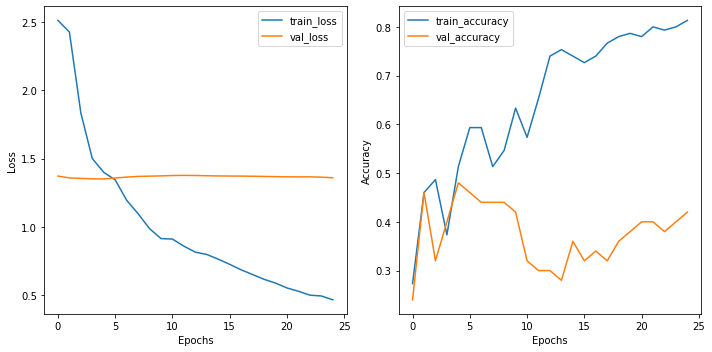

In [137]:
plot_metrics(model_19_results)

Decrease params - the first dense after flatten has a lot, let's remove it. also removed dense in hidden layers

# Model #20

change num of filters and input units, added dense back in hidden, keep basic arch the same

In [138]:
model_20 = Sequential()

model_20.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(64, 64, 1)))
model_20.add(BatchNormalization())
model_20.add(Dense(32, activation='relu'))
model_20.add(MaxPooling2D(pool_size=(2,2)))
model_20.add(Dropout(0.3))

model_20.add(Flatten())
model_20.add(Dense(16, activation='relu'))
model_20.add(Dense(4, activation='softmax'))

model_20.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall])

model_20.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
dense_96 (Dense)             (None, 62, 62, 32)        1056      
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 30752)             0         
_________________________________________________________________
dense_97 (Dense)             (None, 16)              

In [139]:
model_20_results = model_20.fit(train_images, 
                              train_labels, 
                              validation_split=0.25,
                              batch_size=100, 
                              epochs=25,
                              validation_data=(test_images, test_labels))

Epoch 1/25
2/2 [==============================] - 1s 581ms/step - loss: 4.0994 - accuracy: 0.2533 - precision: 0.3433 - recall: 0.0920 - val_loss: 1.3125 - val_accuracy: 0.3800 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
2/2 [==============================] - 0s 170ms/step - loss: 2.4363 - accuracy: 0.4667 - precision: 0.4589 - recall: 0.4467 - val_loss: 1.3719 - val_accuracy: 0.3600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
2/2 [==============================] - 0s 199ms/step - loss: 2.0352 - accuracy: 0.2867 - precision: 0.2836 - recall: 0.2533 - val_loss: 1.3755 - val_accuracy: 0.3800 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
2/2 [==============================] - 0s 212ms/step - loss: 1.3345 - accuracy: 0.4333 - precision: 0.2857 - recall: 0.0133 - val_loss: 1.3781 - val_accuracy: 0.3800 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
2/2 [==============================] - 0s 206ms/step - loss: 1.3134 -

In [140]:
evaluate_model(model_20)

4/4 [==============================] - 0s 17ms/step - loss: 1.3971 - accuracy: 0.1900 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.36 
Training Accuracy: 0.52 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.4 
Testing Accuracy: 0.19 
Testing Precision: 0.0 
Testing Recall: 0.0


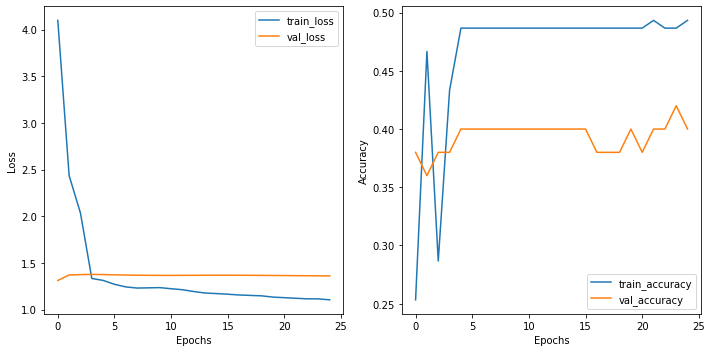

In [141]:
plot_metrics(model_20_results)

# Twenty First Model

try changing the optimizer around, test on this model for
SGD, 
RMSprop, 
Adam, 
Adadelta, 
Adagrad, 
Adamax, 
Nadam, 
Ftrl

In [168]:
model_21 = Sequential()

model_21.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(64, 64, 1)))
model_21.add(BatchNormalization())
model_21.add(Dense(64, activation='relu'))
model_21.add(MaxPooling2D(pool_size=(2,2)))
model_21.add(Dropout(0.3))

model_21.add(Flatten())
model_21.add(Dense(16, activation='relu'))
model_21.add(Dense(8, activation='relu'))
model_21.add(Dense(4, activation='softmax'))

In [169]:
model_21.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
dense_81 (Dense)             (None, 62, 62, 64)        2112      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 61504)             0         
_________________________________________________________________
dense_82 (Dense)             (None, 16)              

In [170]:
results = {}
optimizers = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam']

for optimizer_name in optimizers:
    model = model_21
    optimizer = 'Adam'
    
    if optimizer_name == 'SGD':
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    elif optimizer_name == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
    elif optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    elif optimizer_name == 'Adadelta':
        optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.01)
    elif optimizer_name == 'Adagrad':
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)
    elif optimizer_name == 'Adamax':
        optimizer = tf.keras.optimizers.Adamax(learning_rate=0.01)
    elif optimizer_name == 'Nadam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', precision, recall])
    
    # Train the model
    model_results = model.fit(X_train, 
                              y_train, 
                              batch_size=30, 
                              epochs=20,
                              validation_data=(extra_val_images, extra_val_labels),
                              callbacks=[early_stop],
                              class_weight=class_weights_dict)
    
    # Store the results in the dictionary
    results[optimizer_name] = model_results

Epoch 1/20
5/5 [==============================] - 2s 370ms/step - loss: 1.4258 - accuracy: 0.3067 - precision: 0.7500 - recall: 0.0150 - val_loss: 1.3842 - val_accuracy: 0.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
5/5 [==============================] - 1s 173ms/step - loss: 1.4196 - accuracy: 0.3667 - precision: 0.6364 - recall: 0.0467 - val_loss: 1.3819 - val_accuracy: 0.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
5/5 [==============================] - 1s 168ms/step - loss: 1.3609 - accuracy: 0.3733 - precision: 1.0000 - recall: 0.0400 - val_loss: 1.3837 - val_accuracy: 0.2600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
5/5 [==============================] - 1s 175ms/step - loss: 1.2821 - accuracy: 0.4133 - precision: 0.9091 - recall: 0.0667 - val_loss: 1.3825 - val_accuracy: 0.3300 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
5/5 [==============================] - 1s 176ms/step - loss: 1.2723 -

Epoch 14/20
5/5 [==============================] - 1s 173ms/step - loss: 0.0627 - accuracy: 0.9667 - precision: 0.9795 - recall: 0.9533 - val_loss: 1.4446 - val_accuracy: 0.1900 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 15/20
5/5 [==============================] - 1s 175ms/step - loss: 0.0587 - accuracy: 0.9800 - precision: 0.9797 - recall: 0.9667 - val_loss: 1.4443 - val_accuracy: 0.1900 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 16/20
5/5 [==============================] - 1s 172ms/step - loss: 0.0751 - accuracy: 0.9667 - precision: 0.9662 - recall: 0.9533 - val_loss: 1.4441 - val_accuracy: 0.1900 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 17/20
5/5 [==============================] - 1s 175ms/step - loss: 0.0677 - accuracy: 0.9667 - precision: 0.9796 - recall: 0.9600 - val_loss: 1.4438 - val_accuracy: 0.1900 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 18/20
5/5 [==============================] - 1s 176ms/step - loss: 0.0

In [171]:
# Initialize dictionaries to store average scores for each metric
average_accuracy = {}

for optimizer in optimizers:
    history = results[optimizer].history
    # Calculate the average accuracy for the optimizer
    avg_acc = sum(history['accuracy']) / len(history['accuracy'])
    average_accuracy[optimizer] = avg_acc

# Print the average scores for each optimizer
for optimizer in optimizers:
    print(f"{optimizer}:")
    print(f"Average Accuracy: {average_accuracy[optimizer]}")

SGD:
Average Accuracy: 0.4304761929171426
RMSprop:
Average Accuracy: 0.5146666705608368
Adam:
Average Accuracy: 0.8811111052831014
Adadelta:
Average Accuracy: 0.970333331823349
Adagrad:
Average Accuracy: 0.995555559794108
Adamax:
Average Accuracy: 0.9841666743159294
Nadam:
Average Accuracy: 0.9788888990879059


Nadam seems to have the highest accuracy. Let's try it with Nadam

In [172]:
model_21 = Sequential()

model_21.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(64, 64, 1)))
model_21.add(BatchNormalization())
model_21.add(Dense(64, activation='relu'))
model_21.add(MaxPooling2D(pool_size=(2,2)))
model_21.add(Dropout(0.3))

model_21.add(Flatten())
model_21.add(Dense(16, activation='relu'))
model_21.add(Dense(8, activation='relu'))
model_21.add(Dense(4, activation='softmax'))

In [173]:
model_21.compile(optimizer='Nadam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

model_21_results = model_21.fit(X_train, 
                                y_train, 
                                batch_size=30, 
                                epochs=20,
                                validation_data=(extra_val_images, extra_val_labels),
                                callbacks=[early_stop],
                                class_weight=class_weights_dict)

Epoch 1/20
5/5 [==============================] - 4s 791ms/step - loss: 2.3603 - accuracy: 0.1400 - precision: 0.1287 - recall: 0.0520 - val_loss: 1.3823 - val_accuracy: 0.2800 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
5/5 [==============================] - 1s 170ms/step - loss: 1.3757 - accuracy: 0.1867 - precision: 0.2400 - recall: 0.0400 - val_loss: 1.3850 - val_accuracy: 0.2000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
5/5 [==============================] - 1s 168ms/step - loss: 1.2860 - accuracy: 0.2400 - precision: 0.2609 - recall: 0.0400 - val_loss: 1.3861 - val_accuracy: 0.2100 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
5/5 [==============================] - 1s 173ms/step - loss: 1.3768 - accuracy: 0.2933 - precision: 0.3548 - recall: 0.0733 - val_loss: 1.3872 - val_accuracy: 0.2000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
5/5 [==============================] - 1s 173ms/step - loss: 1.2034 -

In [174]:
evaluate_model(model_21)

2/2 [==============================] - 0s 15ms/step - loss: 1.3822 - accuracy: 0.3400 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.27 
Training Accuracy: 0.753 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.38 
Testing Accuracy: 0.34 
Testing Precision: 0.0 
Testing Recall: 0.0


Let's look at num of epochs and batch size

In [175]:
results_2 = {}
batch_sizes = [10, 20, 30, 40, 50]
epochs = [5, 10, 20, 30, 50]

for batch_size in batch_sizes:
    for epoch in epochs:
        model = model_21
        
        model.compile(optimizer='Adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy', precision, recall])
        
        # Train the model
        model_results = model.fit(X_train, 
                                  y_train, 
                                  batch_size=batch_size, 
                                  epochs=epoch,
                                  validation_data=(extra_val_images, extra_val_labels),
                                  callbacks=[early_stop],
                                  class_weight=class_weights_dict)
        
        # Store the results in a dictionary using the combination of batch size and epochs as keys
        results_2[(batch_size, epoch)] = model_results

Epoch 1/5
15/15 [==============================] - 2s 140ms/step - loss: 0.6326 - accuracy: 0.6667 - precision: 0.7373 - recall: 0.4350 - val_loss: 1.3777 - val_accuracy: 0.2800 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
15/15 [==============================] - 1s 80ms/step - loss: 0.5492 - accuracy: 0.7467 - precision: 0.7739 - recall: 0.5933 - val_loss: 1.3791 - val_accuracy: 0.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
15/15 [==============================] - 1s 81ms/step - loss: 0.4554 - accuracy: 0.7800 - precision: 0.8333 - recall: 0.6667 - val_loss: 1.3972 - val_accuracy: 0.2300 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
15/15 [==============================] - 1s 79ms/step - loss: 0.5251 - accuracy: 0.7800 - precision: 0.8034 - recall: 0.6267 - val_loss: 1.3933 - val_accuracy: 0.2400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
15/15 [==============================] - 1s 78ms/step - loss: 0.5032 

5/5 [==============================] - 1s 189ms/step - loss: 1.2418e-09 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 11.0712 - val_accuracy: 0.2800 - val_precision: 0.2828 - val_recall: 0.2800
Epoch 8/10
5/5 [==============================] - 1s 188ms/step - loss: 3.5580e-09 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 11.0590 - val_accuracy: 0.2800 - val_precision: 0.2828 - val_recall: 0.2800
Epoch 9/10
5/5 [==============================] - 1s 179ms/step - loss: 3.1176e-09 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 11.0417 - val_accuracy: 0.2900 - val_precision: 0.2900 - val_recall: 0.2900
Epoch 10/10
5/5 [==============================] - 1s 185ms/step - loss: 2.5099e-09 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 11.0289 - val_accuracy: 0.2900 - val_precision: 0.2900 - val_recall: 0.2900
Epoch 1/20
5/5 [==============================] - 2s 381ms/step - loss: 4.6060e-09 - accuracy: 1.0000 

4/4 [==============================] - 1s 217ms/step - loss: 1.0480e-09 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 11.6688 - val_accuracy: 0.2800 - val_precision: 0.2800 - val_recall: 0.2800
Epoch 7/50
4/4 [==============================] - 1s 209ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 11.6831 - val_accuracy: 0.2800 - val_precision: 0.2800 - val_recall: 0.2800
Epoch 8/50
4/4 [==============================] - 1s 227ms/step - loss: 2.5809e-09 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 11.6694 - val_accuracy: 0.2800 - val_precision: 0.2800 - val_recall: 0.2800
Epoch 9/50
4/4 [==============================] - 1s 219ms/step - loss: 1.2682e-09 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 11.6637 - val_accuracy: 0.2800 - val_precision: 0.2800 - val_recall: 0.2800
Epoch 10/50
4/4 [==============================] - 1s 221ms/step - loss: 1.4619e-09 - accuracy: 1.0000 

In [176]:
average_accuracy = {}

for batch_size in batch_sizes:
    for epoch in epochs:
        history = results_2[(batch_size, epoch)].history
        avg_acc = sum(history['accuracy']) / len(history['accuracy'])
        average_accuracy[(batch_size, epoch)] = avg_acc

for batch_size in batch_sizes:
    for epoch in epochs:
        print(f"Batch Size {batch_size}, Epochs {epoch}:")
        print(f"Average Accuracy: {average_accuracy[(batch_size, epoch)]}")

Batch Size 10, Epochs 5:
Average Accuracy: 0.7386666655540466
Batch Size 10, Epochs 10:
Average Accuracy: 0.8922222157319387
Batch Size 10, Epochs 20:
Average Accuracy: 0.9561904839106968
Batch Size 10, Epochs 30:
Average Accuracy: 0.9847619192940849
Batch Size 10, Epochs 50:
Average Accuracy: 0.9961904798235212
Batch Size 20, Epochs 5:
Average Accuracy: 1.0
Batch Size 20, Epochs 10:
Average Accuracy: 1.0
Batch Size 20, Epochs 20:
Average Accuracy: 1.0
Batch Size 20, Epochs 30:
Average Accuracy: 1.0
Batch Size 20, Epochs 50:
Average Accuracy: 1.0
Batch Size 30, Epochs 5:
Average Accuracy: 1.0
Batch Size 30, Epochs 10:
Average Accuracy: 1.0
Batch Size 30, Epochs 20:
Average Accuracy: 1.0
Batch Size 30, Epochs 30:
Average Accuracy: 1.0
Batch Size 30, Epochs 50:
Average Accuracy: 1.0
Batch Size 40, Epochs 5:
Average Accuracy: 1.0
Batch Size 40, Epochs 10:
Average Accuracy: 1.0
Batch Size 40, Epochs 20:
Average Accuracy: 1.0
Batch Size 40, Epochs 30:
Average Accuracy: 1.0
Batch Size 40, Ep

Batch Size 10, Epochs 20 looks like a good accuracy score, let's try it out.

In [177]:
model_21 = Sequential()

model_21.add(Conv2D(filters=32, 
                    kernel_size=(3,3), 
                    activation='relu', 
                    input_shape=(64, 64, 1)))

model_21.add(BatchNormalization())
model_21.add(Dense(64, activation='relu'))
model_21.add(MaxPooling2D(pool_size=(2,2)))
model_21.add(Dropout(0.3))

model_21.add(Flatten())
model_21.add(Dense(16, activation='relu'))
model_21.add(Dense(8, activation='relu'))
model_21.add(Dense(4, activation='softmax'))

In [178]:
model_21.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

model_21_results = model_21.fit(X_train, 
                                y_train, 
                                batch_size=10, 
                                epochs=20,
                                validation_data=(extra_val_images, extra_val_labels),
                                callbacks=[early_stop],
                                class_weight=class_weights_dict)

Epoch 1/20
15/15 [==============================] - 2s 142ms/step - loss: 1.5462 - accuracy: 0.3000 - precision: 0.2727 - recall: 0.1200 - val_loss: 1.3854 - val_accuracy: 0.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
15/15 [==============================] - 1s 74ms/step - loss: 1.3864 - accuracy: 0.3133 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3854 - val_accuracy: 0.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
15/15 [==============================] - 1s 78ms/step - loss: 1.3864 - accuracy: 0.3133 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3855 - val_accuracy: 0.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
15/15 [==============================] - 1s 78ms/step - loss: 1.3864 - accuracy: 0.3133 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3854 - val_accuracy: 0.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
15/15 [==============================] -

In [179]:
evaluate_model(model_21)

2/2 [==============================] - 0s 12ms/step - loss: 1.3866 - accuracy: 0.2600 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.39 
Training Accuracy: 0.313 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.39 
Testing Accuracy: 0.26 
Testing Precision: 0.0 
Testing Recall: 0.0


# More models

In [181]:
model_22 = Sequential()

model_22.add(Conv2D(filters=32, 
                    kernel_size=(3,3), 
                    activation='relu', 
                    input_shape=(64, 64, 1), 
                    kernel_regularizer=l2(0.000001)))

model_22.add(BatchNormalization())
model_22.add(Dense(64, activation='relu'))
model_22.add(MaxPooling2D(pool_size=(2,2)))
model_22.add(Dropout(0.3))

model_22.add(Flatten())
model_22.add(Dense(16, activation='relu'))
model_22.add(Dropout(0.2))
model_22.add(Dense(8, activation='relu'))
model_22.add(Dense(4, activation='softmax', kernel_regularizer=l2(0.000001)))

In [182]:
model_22.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_17 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
dense_93 (Dense)             (None, 62, 62, 64)        2112      
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 61504)             0         
_________________________________________________________________
dense_94 (Dense)             (None, 16)              

In [183]:
model_22.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

model_22_results = model_22.fit(X_train, 
                                y_train, 
                                batch_size=50, 
                                epochs=25,
                                validation_data=(extra_val_images, extra_val_labels),
                                callbacks=[early_stop],
                                class_weight=class_weights_dict)

Epoch 1/25
3/3 [==============================] - 2s 679ms/step - loss: 3.8630 - accuracy: 0.4333 - precision: 0.4312 - recall: 0.2350 - val_loss: 1.3947 - val_accuracy: 0.2100 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
3/3 [==============================] - 1s 257ms/step - loss: 3.0009 - accuracy: 0.2733 - precision: 0.2662 - recall: 0.2467 - val_loss: 1.3798 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
3/3 [==============================] - 1s 256ms/step - loss: 1.6837 - accuracy: 0.4133 - precision: 0.4778 - recall: 0.2867 - val_loss: 1.3898 - val_accuracy: 0.3300 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
3/3 [==============================] - 1s 246ms/step - loss: 1.4023 - accuracy: 0.2267 - precision: 0.2000 - recall: 0.0267 - val_loss: 1.3876 - val_accuracy: 0.2800 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
3/3 [==============================] - 1s 254ms/step - loss: 1.3550 -

In [184]:
evaluate_model(model_22)

2/2 [==============================] - 0s 17ms/step - loss: 1.3957 - accuracy: 0.2400 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.37 
Training Accuracy: 0.3 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.4 
Testing Accuracy: 0.24 
Testing Precision: 0.0 
Testing Recall: 0.0


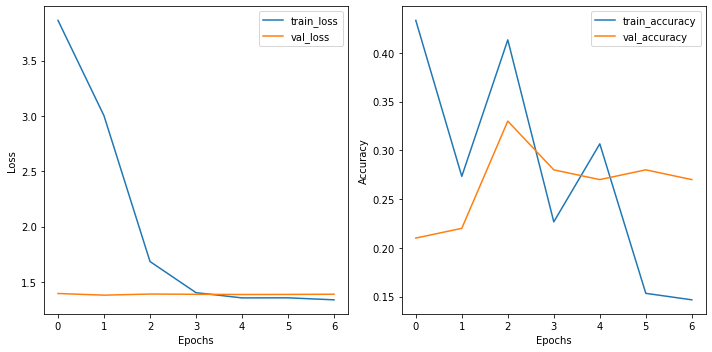

In [185]:
plot_metrics(model_22_results)

# Next one

In [186]:
model_23 = Sequential()

model_23.add(Conv2D(filters=32, 
                    kernel_size=(3, 3), 
                    activation='relu', 
                    input_shape=(64, 64, 1)))

model_23.add(BatchNormalization())
model_23.add(Dense(32, activation='relu'))
model_23.add(MaxPooling2D(pool_size=(2, 2)))

model_23.add(Flatten())
model_23.add(Dense(16, activation='relu'))
model_23.add(Dense(4, activation='softmax'))

In [187]:
model_23.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_18 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
dense_97 (Dense)             (None, 62, 62, 32)        1056      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 30752)             0         
_________________________________________________________________
dense_98 (Dense)             (None, 16)                492048    
_________________________________________________________________
dense_99 (Dense)             (None, 4)               

In [188]:
model_23.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

model_23_results = model_23.fit(X_train, 
                                y_train, 
                                batch_size=50, 
                                epochs=25,
                                validation_data=(extra_val_images, extra_val_labels),
                                callbacks=[early_stop],
                                class_weight=class_weights_dict)

Epoch 1/25
3/3 [==============================] - 2s 506ms/step - loss: 2.0389 - accuracy: 0.3467 - precision: 0.4744 - recall: 0.1850 - val_loss: 1.3888 - val_accuracy: 0.1800 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
3/3 [==============================] - 1s 178ms/step - loss: 2.2253 - accuracy: 0.1200 - precision: 0.1402 - recall: 0.1000 - val_loss: 1.3860 - val_accuracy: 0.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
3/3 [==============================] - 1s 176ms/step - loss: 1.3378 - accuracy: 0.3133 - precision: 1.0000 - recall: 0.0200 - val_loss: 1.3859 - val_accuracy: 0.2600 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
3/3 [==============================] - 1s 175ms/step - loss: 1.3657 - accuracy: 0.3200 - precision: 0.3333 - recall: 0.0067 - val_loss: 1.3856 - val_accuracy: 0.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
3/3 [==============================] - 1s 175ms/step - loss: 1.3708 -

In [189]:
evaluate_model(model_23)

2/2 [==============================] - 0s 15ms/step - loss: 1.3888 - accuracy: 0.2400 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.38 
Training Accuracy: 0.32 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.39 
Testing Accuracy: 0.24 
Testing Precision: 0.0 
Testing Recall: 0.0


# Again

In [190]:
model_24 = Sequential()

model_24.add(Conv2D(filters=16, 
                    kernel_size=(3, 3), 
                    activation='relu', 
                    input_shape=(64, 64, 1)))

model_24.add(MaxPooling2D(pool_size=(2, 2)))
model_24.add(Flatten())
model_24.add(Dense(4, activation='softmax'))

In [191]:
model_24.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 62, 62, 16)        160       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 31, 31, 16)        0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 15376)             0         
_________________________________________________________________
dense_100 (Dense)            (None, 4)                 61508     
Total params: 61,668
Trainable params: 61,668
Non-trainable params: 0
_________________________________________________________________


In [192]:
model_24.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

model_24_results = model_24.fit(X_train, 
                                y_train, 
                                batch_size=30, 
                                epochs=15,
                                validation_data=(extra_val_images, extra_val_labels),
                                callbacks=[early_stop],
                                class_weight=class_weights_dict)

Epoch 1/15
5/5 [==============================] - 1s 221ms/step - loss: 1.4201 - accuracy: 0.1867 - precision: 0.7500 - recall: 0.0150 - val_loss: 1.4328 - val_accuracy: 0.2700 - val_precision: 0.2500 - val_recall: 0.0100
Epoch 2/15
5/5 [==============================] - 0s 39ms/step - loss: 1.2915 - accuracy: 0.5733 - precision: 0.9091 - recall: 0.0667 - val_loss: 1.4043 - val_accuracy: 0.2500 - val_precision: 0.2500 - val_recall: 0.0100
Epoch 3/15
5/5 [==============================] - 0s 41ms/step - loss: 1.1950 - accuracy: 0.5600 - precision: 1.0000 - recall: 0.0400 - val_loss: 1.3966 - val_accuracy: 0.3000 - val_precision: 0.2000 - val_recall: 0.0100
Epoch 4/15
5/5 [==============================] - 0s 38ms/step - loss: 1.1243 - accuracy: 0.5733 - precision: 0.8667 - recall: 0.0867 - val_loss: 1.4473 - val_accuracy: 0.2300 - val_precision: 0.1250 - val_recall: 0.0100
Epoch 5/15
5/5 [==============================] - 0s 41ms/step - loss: 1.0455 - accuracy: 0.6667 - precision: 0.900

In [193]:
evaluate_model(model_24)

2/2 [==============================] - 0s 8ms/step - loss: 1.5233 - accuracy: 0.2800 - precision: 0.2800 - recall: 0.1400
Training Loss: 0.79 
Training Accuracy: 0.747 
Training Precision: 0.916 
Training Recall: 0.507
---------------------------
Testing Loss: 1.52 
Testing Accuracy: 0.28 
Testing Precision: 0.28 
Testing Recall: 0.14


Let's check out testing the batches, epochs, and optimizers here on this one all at once. 

In [194]:
results_combined = {}
optimizers = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl']
batch_sizes = [10, 20, 30, 40, 50]
epochs = [5, 10, 20, 30, 50]

model = model_24  # Assuming you have defined model_21 previously

for optimizer_name in optimizers:
    for batch_size in batch_sizes:
        for epoch in epochs:
            optimizer = 'Adam'
            
            if optimizer_name == 'SGD':
                optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
            elif optimizer_name == 'RMSprop':
                optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
            elif optimizer_name == 'Adam':
                optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
            elif optimizer_name == 'Adadelta':
                optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.01)
            elif optimizer_name == 'Adagrad':
                optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)
            elif optimizer_name == 'Adamax':
                optimizer = tf.keras.optimizers.Adamax(learning_rate=0.01)
            elif optimizer_name == 'Nadam':
                optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
            elif optimizer_name == 'Ftrl':
                optimizer = tf.keras.optimizers.Ftrl(learning_rate=0.01)
            
            model.compile(optimizer=optimizer,
                          loss='categorical_crossentropy',
                          metrics=['accuracy', precision, recall])
            
            model_results = model.fit(X_train, 
                                      y_train, 
                                      batch_size=batch_size, 
                                      epochs=epoch,
                                      validation_data=(extra_val_images, extra_val_labels),
                                      callbacks=[early_stop],
                                      class_weight=class_weights_dict)
            
            results_combined[(optimizer_name, batch_size, epoch)] = model_results

Epoch 1/5
15/15 [==============================] - 1s 80ms/step - loss: 0.7887 - accuracy: 0.7533 - precision: 0.7315 - recall: 0.3950 - val_loss: 1.5016 - val_accuracy: 0.2000 - val_precision: 0.2000 - val_recall: 0.0400
Epoch 2/5
15/15 [==============================] - 0s 19ms/step - loss: 0.7589 - accuracy: 0.7533 - precision: 0.9000 - recall: 0.4800 - val_loss: 1.5025 - val_accuracy: 0.2300 - val_precision: 0.2381 - val_recall: 0.0500
Epoch 3/5
15/15 [==============================] - 0s 18ms/step - loss: 0.7276 - accuracy: 0.7533 - precision: 0.8966 - recall: 0.5200 - val_loss: 1.6263 - val_accuracy: 0.2100 - val_precision: 0.1714 - val_recall: 0.0600
Epoch 4/5
15/15 [==============================] - 0s 18ms/step - loss: 0.7283 - accuracy: 0.7667 - precision: 0.8750 - recall: 0.5600 - val_loss: 1.5988 - val_accuracy: 0.2300 - val_precision: 0.2093 - val_recall: 0.0900
Epoch 5/5
15/15 [==============================] - 0s 19ms/step - loss: 0.6837 - accuracy: 0.7867 - precision: 0

Epoch 7/50
15/15 [==============================] - 0s 21ms/step - loss: 0.2297 - accuracy: 0.9533 - precision: 0.9714 - recall: 0.9067 - val_loss: 2.2166 - val_accuracy: 0.2900 - val_precision: 0.2568 - val_recall: 0.1900
Epoch 1/5
8/8 [==============================] - 1s 143ms/step - loss: 0.2118 - accuracy: 0.9400 - precision: 0.7264 - recall: 0.6160 - val_loss: 2.2734 - val_accuracy: 0.2600 - val_precision: 0.2800 - val_recall: 0.2100
Epoch 2/5
8/8 [==============================] - 0s 31ms/step - loss: 0.2106 - accuracy: 0.9467 - precision: 0.9786 - recall: 0.9133 - val_loss: 2.2493 - val_accuracy: 0.2900 - val_precision: 0.2817 - val_recall: 0.2000
Epoch 3/5
8/8 [==============================] - 0s 31ms/step - loss: 0.2066 - accuracy: 0.9533 - precision: 0.9928 - recall: 0.9200 - val_loss: 2.2315 - val_accuracy: 0.3000 - val_precision: 0.2754 - val_recall: 0.1900
Epoch 4/5
8/8 [==============================] - 0s 31ms/step - loss: 0.2076 - accuracy: 0.9400 - precision: 0.9928 

4/4 [==============================] - 0s 51ms/step - loss: 0.0961 - accuracy: 1.0000 - precision: 1.0000 - recall: 0.9933 - val_loss: 2.6985 - val_accuracy: 0.2900 - val_precision: 0.3125 - val_recall: 0.2500
Epoch 1/20
4/4 [==============================] - 1s 286ms/step - loss: 0.0957 - accuracy: 1.0000 - precision: 0.7598 - recall: 0.6960 - val_loss: 2.6981 - val_accuracy: 0.3000 - val_precision: 0.3133 - val_recall: 0.2600
Epoch 2/20
4/4 [==============================] - 0s 50ms/step - loss: 0.0949 - accuracy: 1.0000 - precision: 1.0000 - recall: 0.9933 - val_loss: 2.6969 - val_accuracy: 0.3000 - val_precision: 0.3049 - val_recall: 0.2500
Epoch 3/20
4/4 [==============================] - 0s 52ms/step - loss: 0.0950 - accuracy: 1.0000 - precision: 1.0000 - recall: 0.9933 - val_loss: 2.7347 - val_accuracy: 0.2800 - val_precision: 0.3210 - val_recall: 0.2600
Epoch 4/20
4/4 [==============================] - 0s 51ms/step - loss: 0.0936 - accuracy: 1.0000 - precision: 1.0000 - recall:

Epoch 6/20
15/15 [==============================] - 0s 20ms/step - loss: 7.7679e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 8.8286 - val_accuracy: 0.2900 - val_precision: 0.2755 - val_recall: 0.2700
Epoch 1/30
15/15 [==============================] - 1s 82ms/step - loss: 0.6405 - accuracy: 0.9333 - precision: 0.6734 - recall: 0.6680 - val_loss: 8.8681 - val_accuracy: 0.3200 - val_precision: 0.3232 - val_recall: 0.3200
Epoch 2/30
15/15 [==============================] - 0s 20ms/step - loss: 0.0561 - accuracy: 0.9800 - precision: 0.9800 - recall: 0.9800 - val_loss: 7.9165 - val_accuracy: 0.2800 - val_precision: 0.2857 - val_recall: 0.2800
Epoch 3/30
15/15 [==============================] - 0s 19ms/step - loss: 9.1523e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 8.0266 - val_accuracy: 0.3000 - val_precision: 0.2990 - val_recall: 0.2900
Epoch 4/30
15/15 [==============================] - 0s 20ms/step - loss: 2.4851e-04 - accuracy: 1.00

5/5 [==============================] - 0s 42ms/step - loss: 2.9213e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 12.7955 - val_accuracy: 0.2900 - val_precision: 0.2900 - val_recall: 0.2900
Epoch 3/30
5/5 [==============================] - 0s 41ms/step - loss: 1.0001e-06 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 12.8564 - val_accuracy: 0.2900 - val_precision: 0.2900 - val_recall: 0.2900
Epoch 4/30
5/5 [==============================] - 0s 44ms/step - loss: 9.6695e-07 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 12.9041 - val_accuracy: 0.2900 - val_precision: 0.2900 - val_recall: 0.2900
Epoch 5/30
5/5 [==============================] - 0s 43ms/step - loss: 9.3088e-07 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 12.9441 - val_accuracy: 0.2900 - val_precision: 0.2900 - val_recall: 0.2900
Epoch 6/30
5/5 [==============================] - 0s 40ms/step - loss: 8.9893e-07 - accuracy: 1.0000 - prec

Epoch 1/5
15/15 [==============================] - 1s 82ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7080 - recall: 0.7080 - val_loss: 20.7628 - val_accuracy: 0.2700 - val_precision: 0.2700 - val_recall: 0.2700
Epoch 2/5
15/15 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 20.7760 - val_accuracy: 0.2700 - val_precision: 0.2700 - val_recall: 0.2700
Epoch 3/5
15/15 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 20.7973 - val_accuracy: 0.2700 - val_precision: 0.2700 - val_recall: 0.2700
Epoch 4/5
15/15 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 20.8220 - val_accuracy: 0.2700 - val_precision: 0.2700 - val_recall: 0.2700
Epoch 5/5
15/15 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accurac

8/8 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 22.0056 - val_accuracy: 0.2700 - val_precision: 0.2700 - val_recall: 0.2700
Epoch 4/10
8/8 [==============================] - 0s 18ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 22.0549 - val_accuracy: 0.2700 - val_precision: 0.2700 - val_recall: 0.2700
Epoch 5/10
8/8 [==============================] - 0s 17ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 22.1550 - val_accuracy: 0.2700 - val_precision: 0.2700 - val_recall: 0.2700
Epoch 6/10
8/8 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 22.2911 - val_accuracy: 0.2700 - val_precision: 0.2700 - val_recall: 0.2700
Epoch 7/10
8/8 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - prec

4/4 [==============================] - 0s 25ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 24.0306 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 5/20
4/4 [==============================] - 0s 26ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 24.2253 - val_accuracy: 0.2700 - val_precision: 0.2700 - val_recall: 0.2700
Epoch 6/20
4/4 [==============================] - 0s 30ms/step - loss: 3.5062e-09 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 24.3134 - val_accuracy: 0.2700 - val_precision: 0.2700 - val_recall: 0.2700
Epoch 1/30
4/4 [==============================] - 1s 135ms/step - loss: 1.7531e-09 - accuracy: 1.0000 - precision: 0.7080 - recall: 0.7080 - val_loss: 24.3084 - val_accuracy: 0.2700 - val_precision: 0.2700 - val_recall: 0.2700
Epoch 2/30
4/4 [==============================] - 0s 25ms/step - loss: 1.7531e-09 - accuracy: 1.0000 - pre

Epoch 5/30
15/15 [==============================] - 0s 17ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.8233 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 6/30
15/15 [==============================] - 0s 17ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.8233 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 1/50
15/15 [==============================] - 1s 40ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 0.7040 - recall: 0.7040 - val_loss: 25.8233 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 2/50
15/15 [==============================] - 0s 11ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.8233 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 3/50
15/15 [==============================] - 0s 18ms/step - loss: 4.1392e-10 - ac

4/4 [==============================] - 0s 21ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.8233 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 3/10
4/4 [==============================] - 0s 20ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.8233 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 4/10
4/4 [==============================] - 0s 23ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.8233 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 5/10
4/4 [==============================] - 0s 22ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.8233 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 6/10
4/4 [==============================] - 0s 24ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - prec

15/15 [==============================] - 0s 12ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.8234 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 3/30
15/15 [==============================] - 0s 14ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.8234 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 4/30
15/15 [==============================] - 0s 15ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.8234 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 5/30
15/15 [==============================] - 0s 14ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.8234 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 6/30
15/15 [==============================] - 0s 16ms/step - loss: 4.1392e-10 - accuracy: 1.0

Epoch 2/5
4/4 [==============================] - 0s 32ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.8235 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 3/5
4/4 [==============================] - 0s 32ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.8235 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 4/5
4/4 [==============================] - 0s 38ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.8235 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 5/5
4/4 [==============================] - 0s 43ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.8235 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 1/10
4/4 [==============================] - 1s 191ms/step - loss: 4.1392e-10 - accuracy: 1.000

Epoch 4/10
3/3 [==============================] - 0s 47ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.8235 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 5/10
3/3 [==============================] - 0s 54ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.8235 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 6/10
3/3 [==============================] - 0s 51ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.8235 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 1/20
3/3 [==============================] - 1s 282ms/step - loss: 4.1392e-10 - accuracy: 1.0000 - precision: 0.7040 - recall: 0.7040 - val_loss: 25.8235 - val_accuracy: 0.2600 - val_precision: 0.2600 - val_recall: 0.2600
Epoch 2/20
3/3 [==============================] - 0s 39ms/step - loss: 4.1392e-10 - accuracy: 1

8/8 [==============================] - 1s 109ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7120 - recall: 0.7120 - val_loss: 25.9399 - val_accuracy: 0.2800 - val_precision: 0.2800 - val_recall: 0.2800
Epoch 2/30
8/8 [==============================] - 0s 21ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.9412 - val_accuracy: 0.2800 - val_precision: 0.2800 - val_recall: 0.2800
Epoch 3/30
8/8 [==============================] - 0s 23ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.9429 - val_accuracy: 0.2800 - val_precision: 0.2800 - val_recall: 0.2800
Epoch 4/30
8/8 [==============================] - 0s 27ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 25.9444 - val_accuracy: 0.2800 - val_precision: 0.2800 - val_recall: 0.2800
Epoch 5/30
8/8 [==============================] - 0s 31ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - pre

3/3 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 26.0011 - val_accuracy: 0.2800 - val_precision: 0.2800 - val_recall: 0.2800
Epoch 4/5
3/3 [==============================] - 0s 46ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 26.0015 - val_accuracy: 0.2800 - val_precision: 0.2800 - val_recall: 0.2800
Epoch 5/5
3/3 [==============================] - 0s 54ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 26.0021 - val_accuracy: 0.2800 - val_precision: 0.2800 - val_recall: 0.2800
Epoch 1/10
3/3 [==============================] - 1s 222ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7120 - recall: 0.7120 - val_loss: 26.0028 - val_accuracy: 0.2800 - val_precision: 0.2800 - val_recall: 0.2800
Epoch 2/10
3/3 [==============================] - 0s 34ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - preci

8/8 [==============================] - 0s 22ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 26.0950 - val_accuracy: 0.2800 - val_precision: 0.2800 - val_recall: 0.2800
Epoch 1/30
8/8 [==============================] - 1s 95ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7120 - recall: 0.7120 - val_loss: 26.0959 - val_accuracy: 0.2800 - val_precision: 0.2800 - val_recall: 0.2800
Epoch 2/30
8/8 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 26.0969 - val_accuracy: 0.2800 - val_precision: 0.2800 - val_recall: 0.2800
Epoch 3/30
8/8 [==============================] - 0s 19ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 26.0979 - val_accuracy: 0.2800 - val_precision: 0.2800 - val_recall: 0.2800
Epoch 4/30
8/8 [==============================] - 0s 20ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - prec

Epoch 1/5
3/3 [==============================] - 1s 205ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 0.7149 - recall: 0.7120 - val_loss: 26.1410 - val_accuracy: 0.2800 - val_precision: 0.2828 - val_recall: 0.2800
Epoch 2/5
3/3 [==============================] - 0s 29ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 26.1413 - val_accuracy: 0.2800 - val_precision: 0.2828 - val_recall: 0.2800
Epoch 3/5
3/3 [==============================] - 0s 39ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 26.1416 - val_accuracy: 0.2800 - val_precision: 0.2828 - val_recall: 0.2800
Epoch 4/5
3/3 [==============================] - 0s 40ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 26.1419 - val_accuracy: 0.2800 - val_precision: 0.2828 - val_recall: 0.2800
Epoch 5/5
3/3 [==============================] - 0s 37ms/step - loss: 0.0000e+00 - accuracy: 1.0000

Epoch 3/10
15/15 [==============================] - 0s 15ms/step - loss: 1.3869 - accuracy: 0.0933 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3855 - val_accuracy: 0.3400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
15/15 [==============================] - 0s 16ms/step - loss: 1.3868 - accuracy: 0.0933 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3855 - val_accuracy: 0.3400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
15/15 [==============================] - 0s 16ms/step - loss: 1.3866 - accuracy: 0.0933 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3855 - val_accuracy: 0.3400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/10
15/15 [==============================] - 0s 16ms/step - loss: 1.3866 - accuracy: 0.0933 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3855 - val_accuracy: 0.3400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 7/10
15/15 [==========================

Epoch 21/30
15/15 [==============================] - 0s 20ms/step - loss: 1.3864 - accuracy: 0.1133 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3865 - val_accuracy: 0.1700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 22/30
15/15 [==============================] - 0s 18ms/step - loss: 1.3865 - accuracy: 0.1133 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3865 - val_accuracy: 0.1700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 23/30
15/15 [==============================] - 0s 18ms/step - loss: 1.3864 - accuracy: 0.1533 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3865 - val_accuracy: 0.1700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 24/30
15/15 [==============================] - 0s 19ms/step - loss: 1.3865 - accuracy: 0.1000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3865 - val_accuracy: 0.1700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 25/30
15/15 [=====================

Epoch 3/10
5/5 [==============================] - 0s 29ms/step - loss: 1.3865 - accuracy: 0.3200 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3863 - val_accuracy: 0.1700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 0s 28ms/step - loss: 1.3866 - accuracy: 0.2067 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3863 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
5/5 [==============================] - 0s 35ms/step - loss: 1.3869 - accuracy: 0.3267 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3863 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/10
5/5 [==============================] - 0s 39ms/step - loss: 1.3866 - accuracy: 0.3133 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3863 - val_accuracy: 0.2200 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 7/10
5/5 [==============================] - 0s

4/4 [==============================] - 0s 36ms/step - loss: 1.3865 - accuracy: 0.2333 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3862 - val_accuracy: 0.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 7/30
4/4 [==============================] - 0s 39ms/step - loss: 1.3866 - accuracy: 0.3133 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3861 - val_accuracy: 0.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 8/30
4/4 [==============================] - 0s 41ms/step - loss: 1.3864 - accuracy: 0.3133 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3860 - val_accuracy: 0.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 9/30
4/4 [==============================] - 0s 39ms/step - loss: 1.3863 - accuracy: 0.3133 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3860 - val_accuracy: 0.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 10/30
4/4 [==============================] - 0s 36ms/step

In [195]:
average_accuracy = {}

for optimizer in optimizers: 
    for batch_size in batch_sizes:
        for epoch in epochs:
            history = results_combined[(optimizer, batch_size, epoch)].history
            avg_acc = sum(history['accuracy']) / len(history['accuracy'])
            average_accuracy[(optimizer, batch_size, epoch)] = avg_acc


for optimizer in optimizers: 
    for batch_size in batch_sizes:
        for epoch in epochs:
            print(f"Optimizer {optimizer}, Batch Size {batch_size}, Epochs {epoch}:")
            print(f"Average Accuracy: {average_accuracy[(optimizer, batch_size, epoch)]}")

Optimizer SGD, Batch Size 10, Epochs 5:
Average Accuracy: 0.762666666507721
Optimizer SGD, Batch Size 10, Epochs 10:
Average Accuracy: 0.8103703724013435
Optimizer SGD, Batch Size 10, Epochs 20:
Average Accuracy: 0.8622222277853224
Optimizer SGD, Batch Size 10, Epochs 30:
Average Accuracy: 0.9091666713356972
Optimizer SGD, Batch Size 10, Epochs 50:
Average Accuracy: 0.9447618978364127
Optimizer SGD, Batch Size 20, Epochs 5:
Average Accuracy: 0.9479999899864197
Optimizer SGD, Batch Size 20, Epochs 10:
Average Accuracy: 0.9699999988079071
Optimizer SGD, Batch Size 20, Epochs 20:
Average Accuracy: 0.9744444489479065
Optimizer SGD, Batch Size 20, Epochs 30:
Average Accuracy: 0.9833333492279053
Optimizer SGD, Batch Size 20, Epochs 50:
Average Accuracy: 0.9847619192940849
Optimizer SGD, Batch Size 30, Epochs 5:
Average Accuracy: 0.9946666717529297
Optimizer SGD, Batch Size 30, Epochs 10:
Average Accuracy: 0.9923809596470424
Optimizer SGD, Batch Size 30, Epochs 20:
Average Accuracy: 0.9942857

let's try : Optimizer SGD, Batch Size 10, Epochs 50:

In [196]:
model_24 = Sequential()

model_24.add(Conv2D(filters=16, 
                    kernel_size=(3, 3), 
                    activation='relu', 
                    input_shape=(64, 64, 1)))

model_24.add(MaxPooling2D(pool_size=(2, 2)))
model_24.add(Flatten())
model_24.add(Dense(4, activation='softmax'))

In [197]:
model_24.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

model_24_results = model_24.fit(X_train, 
                                y_train, 
                                batch_size=10, 
                                epochs=50,
                                validation_data=(extra_val_images, extra_val_labels),
                                callbacks=[early_stop],
                                class_weight=class_weights_dict)

Epoch 1/50
15/15 [==============================] - 1s 38ms/step - loss: 1.4094 - accuracy: 0.2067 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3889 - val_accuracy: 0.2300 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 12ms/step - loss: 1.3646 - accuracy: 0.3533 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4012 - val_accuracy: 0.2800 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 0s 12ms/step - loss: 1.3399 - accuracy: 0.4667 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3785 - val_accuracy: 0.2700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 0s 10ms/step - loss: 1.3080 - accuracy: 0.3800 - precision: 1.0000 - recall: 0.0133 - val_loss: 1.3918 - val_accuracy: 0.2400 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 

In [198]:
evaluate_model(model_24)

2/2 [==============================] - 0s 4ms/step - loss: 1.4680 - accuracy: 0.2800 - precision: 0.3333 - recall: 0.0200
Training Loss: 1.14 
Training Accuracy: 0.58 
Training Precision: 0.929 
Training Recall: 0.0867
---------------------------
Testing Loss: 1.47 
Testing Accuracy: 0.28 
Testing Precision: 0.333 
Testing Recall: 0.02


SGD is sensitive to learning rate, let's play with that

In [201]:
learning_rate_results = {}
learning_rates = [0.00001, 0.001, 0.01, 0.1, 1]

for rate in learning_rates:
    model = model_24
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=rate)
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', precision, recall])
        
    # Train the model
    model_results = model.fit(X_train, 
                              y_train, 
                              batch_size=batch_size, 
                              epochs=epoch,
                              validation_data=(extra_val_images, extra_val_labels),
                              callbacks=[early_stop],
                              class_weight=class_weights_dict)
        
    # Store the results in a dictionary using the learning rate as the key
    learning_rate_results[rate] = model_results

Epoch 1/50
3/3 [==============================] - 0s 166ms/step - loss: 1.1570 - accuracy: 0.5800 - precision: 0.9286 - recall: 0.0520 - val_loss: 1.4215 - val_accuracy: 0.2700 - val_precision: 0.1111 - val_recall: 0.0100
Epoch 2/50
3/3 [==============================] - 0s 34ms/step - loss: 1.1570 - accuracy: 0.5800 - precision: 0.9286 - recall: 0.0867 - val_loss: 1.4215 - val_accuracy: 0.2700 - val_precision: 0.1111 - val_recall: 0.0100
Epoch 3/50
3/3 [==============================] - 0s 26ms/step - loss: 1.1570 - accuracy: 0.5800 - precision: 0.9286 - recall: 0.0867 - val_loss: 1.4215 - val_accuracy: 0.2700 - val_precision: 0.1111 - val_recall: 0.0100
Epoch 4/50
3/3 [==============================] - 0s 25ms/step - loss: 1.1570 - accuracy: 0.5800 - precision: 0.9286 - recall: 0.0867 - val_loss: 1.4215 - val_accuracy: 0.2700 - val_precision: 0.1111 - val_recall: 0.0100
Epoch 5/50
3/3 [==============================] - 0s 29ms/step - loss: 1.1569 - accuracy: 0.5800 - precision: 0.928

Epoch 11/50
3/3 [==============================] - 0s 31ms/step - loss: 1.3895 - accuracy: 0.0933 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3884 - val_accuracy: 0.1700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 12/50
3/3 [==============================] - 0s 41ms/step - loss: 1.3911 - accuracy: 0.3267 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3870 - val_accuracy: 0.1700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 13/50
3/3 [==============================] - 0s 26ms/step - loss: 1.3929 - accuracy: 0.2067 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3916 - val_accuracy: 0.1700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 14/50
3/3 [==============================] - 0s 31ms/step - loss: 1.4060 - accuracy: 0.1200 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3916 - val_accuracy: 0.1700 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


In [202]:
average_accuracy = {}

for rate in learning_rates: 
    history = learning_rate_results[rate].history
    avg_acc = sum(history['accuracy']) / len(history['accuracy'])
    average_accuracy[rate] = avg_acc

for rate in learning_rates: 
    print(f"Learning Rate {rate}:")
    print(f"Average Accuracy: {average_accuracy[rate]}")

Learning Rate 1e-05:
Average Accuracy: 0.5799999833106995
Learning Rate 0.001:
Average Accuracy: 0.5744444330533346
Learning Rate 0.01:
Average Accuracy: 0.5666666626930237
Learning Rate 0.1:
Average Accuracy: 0.5323809470449176
Learning Rate 1:
Average Accuracy: 0.20619047539574759


Let's try 1e-05.

In [203]:
model_24 = Sequential()

model_24.add(Conv2D(filters=16, 
                    kernel_size=(3, 3), 
                    activation='relu', 
                    input_shape=(64, 64, 1)))

model_24.add(MaxPooling2D(pool_size=(2, 2)))
model_24.add(Flatten())
model_24.add(Dense(4, activation='softmax'))

In [205]:
model_24.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy', precision, recall])

model_24_results = model_24.fit(X_train, 
                                y_train, 
                                batch_size=10, 
                                epochs=50,
                                validation_data=(extra_val_images, extra_val_labels),
                                callbacks=[early_stop],
                                class_weight=class_weights_dict)

Epoch 1/50
15/15 [==============================] - 1s 43ms/step - loss: 1.3936 - accuracy: 0.2267 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4011 - val_accuracy: 0.2500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 11ms/step - loss: 1.3935 - accuracy: 0.2267 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4010 - val_accuracy: 0.2500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 0s 12ms/step - loss: 1.3934 - accuracy: 0.2267 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4010 - val_accuracy: 0.2500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 0s 12ms/step - loss: 1.3933 - accuracy: 0.2267 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4009 - val_accuracy: 0.2500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
15/15 [==========================

In [206]:
evaluate_model(model_24)

2/2 [==============================] - 0s 7ms/step - loss: 1.4041 - accuracy: 0.2400 - precision: 0.0000e+00 - recall: 0.0000e+00
Training Loss: 1.41 
Training Accuracy: 0.233 
Training Precision: 0.0 
Training Recall: 0.0
---------------------------
Testing Loss: 1.4 
Testing Accuracy: 0.24 
Testing Precision: 0.0 
Testing Recall: 0.0


# Pre-trained models

There are a number of pre-trained models that might help performance. Starting with VGG16.

In [37]:
from tensorflow.keras.applications.vgg16 import VGG16

In [41]:
# include_top = false so we can customize the number of classes
vgg_model = VGG16(include_top=False, 
                  input_shape=(64, 64, 3), 
                  classes=4)

In [ ]:
# oooook, time to try another method. 
# try data augmentation
# need to do the train test split first and then augment
# research and find out how to do that
# maybe load in normally, do the split, then reload the train as augmented and just using xtrain, ytrain?

# Let's try grid searching

In [290]:
def build_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(64, 64, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', precision, recall])
    
    return model

In [291]:
model = build_model()

In [292]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization_25 (Batc (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_77 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_78 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 12, 12, 16)      

In [293]:
keras_model = KerasClassifier(build_fn=build_model,
                              epochs=50,
                              batch_size=150,
                              verbose=1)

In [294]:
nn_pipe = Pipeline(steps=[('nn', keras_model)])
nn_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'nn', 'nn__epochs', 'nn__batch_size', 'nn__verbose', 'nn__build_fn'])

In [295]:
batch_size = [10, 20, 30]
epochs = [10, 20, 30]
verbose = [1, 2, 3]

param_grid = dict(batch_size=batch_size, epochs=epochs, verbose=verbose)

In [296]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted')
}

In [297]:
nn_gs = GridSearchCV(estimator=keras_model, 
                     param_grid=param_grid, 
                     n_jobs=-1, 
                     cv=3, 
                     scoring=scoring, 
                     refit=False)

In [298]:
with parallel_backend('threading'):
    grid_result = nn_gs.fit(X_train, y_train_multiclass)

Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/10
 2/10 [=====>........................] - ETA: 0s - loss: 1.6760 - accuracy: 0.2500 - precision_1: 0.4757 - recall_1: 0.272210/10 - 1s - loss: 1.2689 - accuracy: 0.4800 - precision_1: 0.5128 - recall_1: 0.2727
Epoch 2/10
10/10 [==============================] - 1s 111ms/step - loss: 1.4433 - accuracy: 0.3100 - precision_1: 0.5111 - recall_1: 0.1150
Epoch 2/10
 8/10 [=======================>......] - ETA: 0s - loss: 1.4836 - accuracy: 0.4000 - precision_1: 0.5147 - recall_1: 0.175010/10 - 1s - loss: 1.1921 - accuracy: 0.4500 - precision_1: 0.5410 - recall_1: 0.1737
Epoch 3/10
10/10 [==============================] - 1s 136ms/step - loss: 1.4460 - accuracy: 0.4000 - precision_1: 0.4000 - recall_1: 0.1833
Epoch 2/10
 1/10 [==>...........................] - ETA: 0s - loss: 1.4615 - accuracy: 0.2000 - precision_1: 0.7059 - recall_1: 0.2400Epoch 3/10
10/10 - 2s - loss: 1.4086 - accuracy: 0.1200 - precision

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 - 2s - loss: 0.8945 - accuracy: 0.6500 - precision_1: 0.7059 - recall_1: 0.6000
Epoch 10/10
 3/10 [========>.....................] - ETA: 1s - loss: 0.5336 - accuracy: 0.9000 - precision_1: 0.7959 - recall_1: 0.4875precision_1: 0.7059 - recall_1: 0.4000 - ETA: 0s - loss: 0.7760 - accuracy: 0.7000 - precision_1: 0.5455 - recall_1: 0.30

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 [==============================] - 2s 250ms/step - loss: 0.7851 - accuracy: 0.6800 - precision_1: 0.7812 - recall_1: 0.4839
Epoch 10/10
 7/10 [====================>.........] - ETA: 0s - loss: 0.7374 - accuracy: 0.7143 - precision_1: 0.7000 - recall_1: 0.700010/10 - 2s - loss: 1.0535 - accuracy: 0.4700 - precision_1: 0.7143 - recall_1: 0.4000
Epoch 1/2
5/5 [==============================] - 0s 24ms/step


C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 - 0s
5/5 - 0s


C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/5 [=======================>......] - ETA: 0s

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 [==============================] - 0s 37ms/step


C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 2/10
10/10 [==============================] - 1s 135ms/step - loss: 1.3140 - accuracy: 0.3800 - precision_1: 0.3878 - recall_1: 0.1267=========================>...] - ETA: 0s - loss: 1.3561 - accuracy: 0.3333 - precision_1: 0.5000 - recall_1: 0.1250 5/10 [==============>...............] - ETA: 0s - loss: 1.3189 - accuracy: 0.3600 - precision_1: 0.4667 - recall_1: 0.1
Epoch 2/20
 5/10 [==============>...............] - ETA: 0s - loss: 1.3462 - accuracy: 0.4400 - precision_1: 0.4706 - recall_1: 0.160010/10 - 1s - loss: 1.4053 - accuracy: 0.2900 - precision_1: 0.4667 - recall_1: 0.2000
Epoch 2/20
10/10 [==============================] - 1s 147ms/step - loss: 1.2571 - accuracy: 0.4400 - precision_1: 0.5918 - recall_1: 0.1933[==========================>...] - ETA: 0s - loss: 1.2501 - accuracy: 0.4333 - precision_1: 0.6296 - recall_1: 0.2
Epoch 2/20
10/10 [==============================] - 2s 159ms/step - loss: 1.2647 - 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 8/10 [=======================>......] - ETA: 0s - loss: 0.8764 - accuracy: 0.6500 - precision_1: 0.7004 - recall_1: 0.4553Epoch 9/20
Epoch 1/20
10/10 - 3s - loss: 0.9634 - accuracy: 0.6100 - precision_1: 0.6250 - recall_1: 0.5000
Epoch 8/20
10/10 - 3s - loss: 0.9554 - accuracy: 0.6200 - precision_1: 0.6667 - recall_1: 0.5000
10/10 [==============================] - 3s 324ms/step - loss: 0.8600 - accuracy: 0.6800 - precision_1: 0.8462 - recall_1: 0.5500
Epoch 9/20
10/10 [==============================] - 3s 345ms/step - loss: 0.9446 - accuracy: 0.5800 - precision_1: 0.7727 - recall_1: 0.5667
Epoch 9/20
10/10 [==============================] - 3s 313ms/step - loss: 0.8943 - accuracy: 0.6700 - precision_1: 0.8235 - recall_1: 0.4667
Epoch 9/20
 8/10 [=======================>......] - ETA: 0s - loss: 0.8391 - accuracy: 0.6625 - precision_1: 0.7449 - recall_1: 0.547510/10 - 3s - loss: 0.9388 - accuracy: 0.6200 - precision_1: 0.6364 - recall_1: 0.3500
Epoch 9/20
 9/10 [======================

Epoch 14/20
10/10 [==============================] - 3s 344ms/step - loss: 0.6314 - accuracy: 0.7600 - precision_1: 0.7778 - recall_1: 0.7000
Epoch 14/20
 8/10 [=======================>......] - ETA: 0s - loss: 0.6321 - accuracy: 0.7375 - precision_1: 0.8161 - recall_1: 0.648710/10 - 3s - loss: 0.5999 - accuracy: 0.7500 - precision_1: 0.8145 - recall_1: 0.6475
Epoch 15/20
 7/10 [====================>.........] - ETA: 0s - loss: 0.6889 - accuracy: 0.7286 - precision_1: 0.7500 - recall_1: 0.650010/10 - 3s - loss: 0.6593 - accuracy: 0.7600 - precision_1: 0.7419 - recall_1: 0.6571
Epoch 14/20
10/10 [==============================] - 3s 337ms/step - loss: 0.5886 - accuracy: 0.7700 - precision_1: 0.7590 - recall_1: 0.6300
Epoch 15/20
 8/10 [=======================>......] - ETA: 0s - loss: 0.6418 - accuracy: 0.7500 - precision_1: 0.8421 - recall_1: 0.800010/10 - 3s - loss: 0.7193 - accuracy: 0.7500 - precision_1: 0.7500 - recall_1: 0.7000
Epoch 14/20
10/10 [==============================] - 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 [==============================] - 0s 91ms/step
Epoch 13/20
2/5 [===========>..................] - ETA: 0s5/5 - 0s
Epoch 14/20
5/5 [==============================] - 0s 90ms/step
Epoch 1/30
5/5 - 0s
Epoch 1/30Epoch 15/20

Epoch 16/20
Epoch 1/30
Epoch 17/20
Epoch 18/20
Epoch 1/30
Epoch 1/30
Epoch 19/20
Epoch 1/30
Epoch 20/20
Epoch 1/30
 8/10 [=======================>......] - ETA: 0s - loss: 1.3474 - accuracy: 0.4125 - precision_1: 0.5376 - recall_1: 0.1462 - ETA: 0s - loss: 1.3742 - accuracy: 0.3400 - precision_1: 0.6458 - recall_1: 0.1802recision_1: 0.5455 - recall10/10 - 2s - loss: 1.2934 - accuracy: 0.3700 - precision_1: 0.5426 - recall_1: 0.1449
Epoch 2/30
10/10 [==============================] - 2s 244ms/step - loss: 1.6801 - accuracy: 0.1500 - precision_1: 0.5192 - recall_1: 0.1414
Epoch 2/30
10/10 [==============================] - 3s 291ms/step - loss: 1.3005 - accuracy: 0.4600 - precision_1: 0.3077 - recall_1: 0.1333
Epoch 2/30
10/10 [==============================] - 4s 4

 8/10 [=======================>......] - ETA: 0s - loss: 0.6542 - accuracy: 0.6875 - precision_1: 0.8110 - recall_1: 0.700010/10 - 3s - loss: 0.6090 - accuracy: 0.7400 - precision_1: 0.8191 - recall_1: 0.7000
Epoch 13/30
 5/10 [==============>...............] - ETA: 1s - loss: 0.7464 - accuracy: 0.6800 - precision_1: 0.8274 - recall_1: 0.708710/10 - 3s - loss: 0.6618 - accuracy: 0.7600 - precision_1: 1.0000 - recall_1: 0.6000
Epoch 14/30
 6/10 [=================>............] - ETA: 1s - loss: 0.7146 - accuracy: 0.7000 - precision_1: 0.8750 - recall_1: 0.700010/10 - 4s - loss: 0.7506 - accuracy: 0.6800 - precision_1: 0.8696 - recall_1: 0.6667
Epoch 13/30
10/10 [==============================] - 3s 336ms/step - loss: 0.6401 - accuracy: 0.7000 - precision_1: 0.8387 - recall_1: 0.6500
Epoch 13/30
10/10 [==============================] - 3s 319ms/step - loss: 0.6690 - accuracy: 0.7300 - precision_1: 0.8000 - recall_1: 0.6286
Epoch 14/30
 8/10 [=======================>......] - ETA: 0s - lo

 9/10 [==========================>...] - ETA: 0s - loss: 0.1352 - accuracy: 0.9778 - precision_1: 0.9655 - recall_1: 0.933310/10 - 3s - loss: 0.1418 - accuracy: 0.9400 - precision_1: 0.9322 - recall_1: 0.7857
Epoch 24/30
10/10 [==============================] - 3s 333ms/step - loss: 0.1289 - accuracy: 0.9800 - precision_1: 1.0000 - recall_1: 1.0000
Epoch 24/30
10/10 [==============================] - 3s 337ms/step - loss: 0.2266 - accuracy: 0.8900 - precision_1: 0.9759 - recall_1: 0.9000
Epoch 25/30
 5/10 [==============>...............] - ETA: 1s - loss: 0.0959 - accuracy: 0.9800 - precision_1: 0.9465 - recall_1: 0.842910/10 - 3s - loss: 0.1487 - accuracy: 0.9600 - precision_1: 1.0000 - recall_1: 1.0000
Epoch 25/30
 6/10 [=================>............] - ETA: 1s - loss: 0.0883 - accuracy: 0.9833 - precision_1: 1.0000 - recall_1: 1.000010/10 - 3s - loss: 0.0288 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 0.8000
Epoch 26/30
10/10 [==============================] - 3s 344ms/ste

10/10 [==============================] - 4s 370ms/step - loss: 0.1714 - accuracy: 0.9200 - precision_1: 0.9333 - recall_1: 0.9333
Epoch 30/30
10/10 [==============================] - 3s 346ms/step - loss: 0.0863 - accuracy: 0.9600 - precision_1: 0.9615 - recall_1: 0.8929
10/10 - 3s - loss: 0.0360 - accuracy: 1.0000 - precision_1: 0.9635 - recall_1: 0.9103precision_1: 0.9631 - recall_1: 0.903
 8/10 [=======================>......] - ETA: 0s - loss: 0.0459 - accuracy: 1.0000 - precision_1: 0.9200 - recall_1: 0.7667Epoch 9/30
 - ETA: 0s - loss: 0.0422 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 8/10 [=======================>......] - ETA: 0s - loss: 0.2581 - accuracy: 0.9125 - precision_1: 0.8611 - recall_1: 0.7710/10 - 3s - loss: 0.0387 - accuracy: 0.9900 - precision_1: 0.8913 - recall_1: 0.8200
10/10 [==============================] - 3s 275ms/step - loss: 0.2175 - accuracy: 0.9300 - precision_1: 0.9035 - recall_1: 0.8583
5/5 - 0s
Epoch 10/30
Epoch 11/30
5/5 - 0s
5/5 [==

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 [==============================] - 3s 531ms/step - loss: 0.8749 - accuracy: 0.6700 - precision_1: 0.7176 - recall_1: 0.5083
Epoch 10/10
Epoch 9/10
5/5 - 3s - loss: 0.8672 - accuracy: 0.6500 - precision_1: 0.7156 - recall_1: 0.4875
Epoch 1/10
4/5 [=======================>......] - ETA: 0s - loss: 0.8706 - accuracy: 0.6375 - precision_1: 0.7807 - recall_1: 0.5676Epoch 16/30
3/3 - 0s
5/5 [==============================] - 2s 353ms/step - loss: 0.8209 - accuracy: 0.6700 - precision_1: 1.0000 - recall_1: 0.6000


C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 0s 122ms/step


C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 - 0s


C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 17/30WARNING:tensorflow:5 out of the last 13 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000019C8B2251F0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.

3/3 - 0s
Epoch 18/30
1/3 [=========>....................] - ETA: 0sWARNING:tensorflow:5 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000019C8B6450D0> triggered tf.function r

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/30
Epoch 1/20
Epoch 21/30
Epoch 1/20
Epoch 22/30
Epoch 1/20
Epoch 1/20
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 1/20
Epoch 30/30
Epoch 1/20
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 2/10
5/5 [==============================] - 2s 371ms/step - loss: 1.3574 - accuracy: 0.4300 - precision_1: 0.5000 - recall_1: 0.2300
Epoch 3/10
Epoch 2/20
5/5 [==============================] - 3s 517ms/step - loss: 1.3037 - accuracy: 0.3800 - precision_1: 0.4667 - recall_1: 0.2625
Epoch 2/20
5/5 - 2s - loss: 1.3129 - accuracy: 0.4800 - precision_1: 0.4830 - recall_1: 0.2731
Epoch 2/20
Epoch 7/1
1/5 [=====>........................] - ETA: 0s - loss: 1.1392 - accuracy: 0.3500 - precision_1: 0.6000 - recall_1: 0.15005/5 - 2s - loss: 1.3728 - accuracy: 0.4300 - precision_1: 0.5000 - recall_1: 0.3750
Epoch 2/20
Epoch 4/10
3/5 [=================>............]5/5 [==============================] - ETA: 0s - loss: 1.1098 - accuracy: 0.4500 - precisi

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 [==============================] - 3s 579ms/step - loss: 0.9832 - accuracy: 0.5500 - precision_1: 0.6392 - recall_1: 0.3875
Epoch 7/20
5/5 [==============================] - 3s 508ms/step - loss: 1.0530 - accuracy: 0.5200 - precision_1: 0.8889 - recall_1: 0.4000
Epoch 7/20
5/5 - 3s - loss: 1.0406 - accuracy: 0.5500 - precision_1: 0.7778 - recall_1: 0.3500
Epoch 7/20
5/5 [==============================] - 3s 528ms/step - loss: 1.0422 - accuracy: 0.5600 - precision_1: 0.7857 - recall_1: 0.5500
Epoch 6/20
1/5 [=====>........................] - ETA: 0s - loss: 1.0256 - accuracy: 0.5500 - precision_1: 0.7692 - recall_1: 0.50005/5 - 2s - loss: 1.0636 - accuracy: 0.5300 - precision_1: 0.6087 - recall_1: 0.3500
Epoch 7/20
3/5 [=================>............] - ETA: 0s - loss: 0.9877 - accuracy: 0.6000 - precision_1: 0.6207 - recall_1: 0.3000Epoch 9/10
5/5 - 2s - loss: 1.0724 - accuracy: 0.5400 - precision_1: 0.7091 - recall_1: 0.3250
Epoch 6/20
5/5 [==============================] - 2s 452

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/5 [===========>..................] - ETA: 0s - loss: 0.8339 - accuracy: 0.6000 - precision_1: 0.7419 - recall_1: 0.57505/5 - 3s - loss: 0.9294 - accuracy: 0.6300 - precision_1: 0.8000 - recall_1: 0.6000
5/5 - 2s - loss: 1.0042 - accuracy: 0.5400 - precision_1: 0.6250 - recall_1: 0.4167
Epoch 10/20
Epoch 10/20
Epoch 1/20
3/5 [=================>............] - ETA: 0s - loss: 0.8397 - accuracy: 0.6167 - precision_1: 0.7857 - recall_1: 0.55005/5 - 2s - loss: 0.9251 - accuracy: 0.6400 - precision_1: 0.7647 - recall_1: 0.4333
Epoch 9/20
5/5 [==============================] - 2s 490ms/step - loss: 0.8268 - accuracy: 0.6500 - precision_1: 0.6875 - recall_1: 0.4125
Epoch 11/20
5/5 [==============================] - 3s 518ms/step - loss: 0.9285 - accuracy: 0.6100 - precision_1: 0.7429 - recall_1: 0.4333
Epoch 11/20
2/5 [===========>..................] - ETA: 0s - loss: 0.7104 - accuracy: 0.7250 - precision_1: 0.7969 - recall_1: 0.51005/5 - 3s - loss: 0.9804 - accuracy: 0.5700 - precision_1: 0

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 - 2s - loss: 0.3844 - accuracy: 0.8600 - precision_1: 0.8610 - recall_1: 0.6400
Epoch 11/20
Epoch 14/20
1/5 [=====>........................] - ETA: 0s - loss: 0.2467 - accuracy: 0.9500 - precision_1: 0.8913 - recall_1: 0.6833Epoch 1/20
3/3 - 0s
5/5 [==============================] - ETA: 0s - loss: 0.3675 - accuracy: 0.8400 - precision_1: 0.8510 - recall_1: 0.6321Epoch 15/20Epoch 12/20

5/5 [==============================] - 1s 291ms/step - loss: 0.3675 - accuracy: 0.8400 - precision_1: 0.8510 - recall_1: 0.6321
Epoch 16/20
Epoch 13/20
3/3 - 0s
Epoch 1/30Epoch 1/30

Epoch 1/30
3/3 [==============================] - 0s 147ms/step
Epoch 14/20
Epoch 18/20
Epoch 15/20
Epoch 19/20
Epoch 16/20
Epoch 1/30
Epoch 20/20
Epoch 17/20
Epoch 1/30
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/30


C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/30
Epoch 2/20
5/5 [==============================] - 1s 128ms/step - loss: 1.4233 - accuracy: 0.3700 - precision_1: 0.6667 - recall_1: 0.1000=========>..................]
 - ETA: 0s - loss: 1.1913 - accuracy: 0.4750 - precision_1: 0.4737 - recall_1: 0.2250Epoch 2/30
5/5 [==============================] - 1s 202ms/step - loss: 1.2045 - accuracy: 0.5000 - precision_1: 0.5588 - recall_1: 0.2192
Epoch 3/30
5/5 [==============================] - 1s 256ms/step - loss: 1.1262 - accuracy: 0.4900 - precision_1: 0.5741 - recall_1: 0.1937====>........................] - ETA: 0s - loss: 1.0720 - accuracy: 0.5500 - precision_1: 0.5455 - recall_1: 0.10
Epoch 3/30
2/5 [===========>..................] - ETA: 0s - loss: 1.0319 - accuracy: 0.5250 - precision_1: 0.6585 - recall_1: 0.2250 - ETA: 0s - loss: 1.2409 - accuracy: 0.5000 - precision_1: 0.6712 - recall_1: 0.22275/5 - 1s - loss: 1.2148 - accuracy: 0.5000 - precision_1: 0.6500 - recall_1: 0.2500
Epoch 2/30
5/5 - 2s - loss: 1.2541 - accurac

Epoch 8/30
5/5 [==============================] - 3s 590ms/step - loss: 0.8524 - accuracy: 0.6300 - precision_1: 0.7613 - recall_1: 0.4214
Epoch 10/30
5/5 [==============================] - 3s 532ms/step - loss: 0.9650 - accuracy: 0.5900 - precision_1: 0.7772 - recall_1: 0.4412
Epoch 10/30
Epoch 12/20
5/5 [==============================] - 3s 583ms/step - loss: 0.8981 - accuracy: 0.6300 - precision_1: 0.5625 - recall_1: 0.4500
Epoch 8/30
1/5 [=====>........................] - ETA: 0s - loss: 0.9258 - accuracy: 0.5500 - precision_1: 0.7534 - recall_1: 0.55005/5 - 3s - loss: 0.9528 - accuracy: 0.6000 - precision_1: 0.7895 - recall_1: 0.5625
Epoch 8/30
2/5 [===========>..................] - ETA: 1s - loss: 0.9546 - accuracy: 0.5750 - precision_1: 0.7396 - recall_1: 0.50715/5 - 3s - loss: 0.9567 - accuracy: 0.6300 - precision_1: 0.7333 - recall_1: 0.5500
Epoch 9/30
2/5 [===========>..................] - ETA: 1s - loss: 0.8160 - accuracy: 0.6500 - precision_1: 0.7538 - recall_1: 0.49005/5 -

5/5 [==============================] - 3s 561ms/step - loss: 0.1788 - accuracy: 0.9500 - precision_1: 0.9382 - recall_1: 0.8350
Epoch 21/30
Epoch 22/30
5/5 [==============================] - 3s 557ms/step - loss: 0.1620 - accuracy: 0.9600 - precision_1: 0.9027 - recall_1: 0.7846
Epoch 23/30
5/5 - 3s - loss: 0.2403 - accuracy: 0.9300 - precision_1: 0.9061 - recall_1: 0.7929
Epoch 21/30
5/5 [==============================] - 3s 513ms/step - loss: 0.5082 - accuracy: 0.8200 - precision_1: 0.9167 - recall_1: 0.8250
Epoch 24/30
1/5 [=====>........................] - ETA: 0s - loss: 0.2075 - accuracy: 0.9500 - precision_1: 0.9474 - recall_1: 0.90005/5 - 3s - loss: 0.1666 - accuracy: 0.9800 - precision_1: 0.9464 - recall_1: 0.8833
Epoch 22/30
4/5 [=======================>......] - ETA: 0s - loss: 0.4846 - accuracy: 0.7875 - precision_1: 0.8971 - recall_1: 0.78505/5 - 3s - loss: 0.3044 - accuracy: 0.9100 - precision_1: 0.9038 - recall_1: 0.7714
Epoch 23/30
5/5 [==============================] -

2/3 [===================>..........] - ETA: 0s - loss: 0.0192 - accuracy: 1.0000 - precision_1: 0.9677 - recall_1: 0.905/5 - 3s - loss: 0.0518 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000
Epoch 29/30
3/3 [==============================] - 0s 95ms/step
Epoch 28/30
5/5 [==============================] - 2s 485ms/step - loss: 0.0509 - accuracy: 1.0000 - precision_1: 0.9717 - recall_1: 0.9167
Epoch 29/30
5/5 [==============================] - 3s 521ms/step - loss: 0.0271 - accuracy: 1.0000 - precision_1: 0.9780 - recall_1: 0.9342
5/5 - 2s - loss: 0.0780 - accuracy: 0.9700 - precision_1: 0.9747 - recall_1: 0.9190
Epoch 30/30
5/5 - 2s - loss: 0.0946 - accuracy: 0.9800 - precision_1: 0.9474 - recall_1: 0.9000
Epoch 29/30
1/5 [=====>........................] - ETA: 0s - loss: 0.0356 - accuracy: 1.0000 - precision_1: 0.9744 - recall_1: 0.95005/5 - 2s - loss: 0.0604 - accuracy: 0.9900 - precision_1: 0.9873 - recall_1: 0.9750
Epoch 30/30
Epoch 29/30
5/5 [===========================

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 14/30
Epoch 15/30
3/3 - 0s
Epoch 16/30
3/3 [==============================] - 0s 71ms/step
Epoch 17/30
Epoch 1/10
Epoch 1/10
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 1/10
Epoch 22/30
Epoch 1/10
Epoch 1/10
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 2/30
Epoch 30/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 1/10
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
4/4 [==============================] - 1s 207ms/step - loss: 1.3751 - accuracy: 0.2900 - precision_1: 1.0000 - recall_1: 0.4333
Epoch 2/10
4/4 [==============================] - 2s 412ms/step - loss: 1.1806 - accuracy: 0.4700 - precision_1: 0.8800 - recall_1: 0.2750
Epoch 25/30
Epoch 3/10
4/4 [==============================] - 2s 390ms/step - loss: 1.4135 - accuracy: 0.2900 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/4 [==============>...............] - ETA: 0s - loss: 1.1267 - accuracy: 0.5667 - precision_1: 0.9231 - recall_1: 0.40004/4 - 2s - loss: 0.8263 - accuracy: 0.6700 - precision_1: 0.7545 - recall_1: 0.4368
Epoch 10/10
4/4 [==============================] - 2s 423ms/step - loss: 1.0972 - accuracy: 0.5600 - precision_1: 0.8571 - recall_1: 0.4500
Epoch 10/10
4/4 - 2s - loss: 0.9069 - accuracy: 0.6700 - precision_1: 0.8571 - recall_1: 0.6000
4/4 - 2s - loss: 0.9714 - accuracy: 0.6000 - precision_1: 0.7143 - recall_1: 0.5000
2/2 [==============================] - 0s 128ms/steps: 1.0744 - accuracy: 0.6667 - precision_1: 0.7143 - recall_1: 0.30
Epoch 9/10
2/4 [==============>...............] - ETA: 0s - loss: 1.0993 - accuracy: 0.5500 - precision_1: 0.7465 - recall_1: 0.3533

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 - 1s - loss: 0.7848 - accuracy: 0.7000 - precision_1: 0.8276 - recall_1: 0.4800
4/4 [==============================] - 1s 295ms/step - loss: 1.0973 - accuracy: 0.5500 - precision_1: 0.7975 - recall_1: 0.4500
Epoch 10/10
2/2 - 0s


C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2/2 - 0s


C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
2/2 - 0s
2/2 [==============================] - 0s 18ms/step


C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 1/20
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/20
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
2/4 [==============>...............] - ETA: 0s - loss: 1.4775 - accuracy: 0.2500 - precision_1: 0.7333 - recall_1: 0.1833

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 [==============================] - 2s 487ms/step - loss: 1.1915 - accuracy: 0.5400 - precision_1: 0.6667 - recall_1: 0.2000
Epoch 3/20
4/4 [==============================] - 2s 479ms/step - loss: 1.4171 - accuracy: 0.3100 - precision_1: 0.1154 - recall_1: 0.0600
Epoch 2/20
4/4 [==============================] - 2s 519ms/step - loss: 1.1666 - accuracy: 0.5100 - precision_1: 0.5714 - recall_1: 0.1500
Epoch 3/20
1/4 [======>.......................]4/4 - 2s - loss: 1.3985 - accuracy: 0.3600 - precision_1: 0.4000 - recall_1: 0.2000
4/4 - 2s - loss: 1.1437 - accuracy: 0.5000 - precision_1: 0.4828 - recall_1: 0.280077
4/4 [==============================] - 2s 480ms/step - loss: 1.1095 - accuracy: 0.5800 - precision_1: 1.0000 - recall_1: 0.7000
Epoch 4/20
4/4 [==============================] - 2s 623ms/step - loss: 1.2209 - accuracy: 0.4800 - precision_1: 0.5357 - recall_1: 0.2143
Epoch 3/20
4/4 [==============================] - 2s 583ms/step - loss: 1.1213 - accuracy: 0.4900 - precision_

2/4 [==============>...............] - ETA: 0s - loss: 0.5639 - accuracy: 0.8167 - precision_1: 0.8387 - recall_1: 0.6500Epoch 13/20
4/4 - 2s - loss: 0.6631 - accuracy: 0.7600 - precision_1: 0.8261 - recall_1: 0.7600
Epoch 16/204/4 - 3s - loss: 0.7843 - accuracy: 0.6900 - precision_1: 0.8302 - recall_1: 0.7333

Epoch 16/20
4/4 [==============================] - 2s 568ms/step - loss: 0.6549 - accuracy: 0.7600 - precision_1: 0.7886 - recall_1: 0.6000
Epoch 18/20
4/4 [==============================] - 2s 568ms/step - loss: 0.8203 - accuracy: 0.7000 - precision_1: 0.8150 - recall_1: 0.6409
Epoch 17/20
4/4 [==============================] - 2s 551ms/step - loss: 0.6418 - accuracy: 0.7700 - precision_1: 1.0000 - recall_1: 0.9000
Epoch 18/20
Epoch 18/20
2/4 [==============>...............] - ETA: 0s - loss: 0.7545 - accuracy: 0.7000 - precision_1: 0.7887 - recall_1: 0.65884/4 - 2s - loss: 0.7194 - accuracy: 0.7300 - precision_1: 0.9310 - recall_1: 0.6750
Epoch 17/20
4/4 - 2s - loss: 0.6211 - 

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 20/20
2/2 - 0s
3/4 [=====================>........] - ETA: 0s - loss: 0.5096 - accuracy: 0.7556 - precision_1: 0.8478 - recall_1: 0.6500

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/20
2/2 [==============================] - 0s 66ms/step 
Epoch 1/20


C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


4/4 - 1s - loss: 0.5322 - accuracy: 0.8400 - precision_1: 0.8203 - recall_1: 0.7120
4/4 - 1s - loss: 0.5386 - accuracy: 0.7900 - precision_1: 0.8312 - recall_1: 0.7296
Epoch 18/20
Epoch 20/20
2/2 [==============================] - 0s 101ms/step


C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 19/20
2/2 - 0s
Epoch 20/20
Epoch 1/30
2/2 - 0s


C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/30
Epoch 1/30WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000019C8EB00700> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.

Epoch 1/30
Epoch 1/30
Epoch 1/30
Epoch 2/20
Epoch 3/20
Epoch 4/20
4/4 [==============================] - 2s 450ms/step - loss: 1.4910 - accuracy: 0.2200 - precision_1: 0.6800 - recall_1: 0.1700
Epoch 2/30
4/4 - 1s - 

Epoch 7/30
4/4 [==============================] - 2s 611ms/step - loss: 0.9578 - accuracy: 0.5800 - precision_1: 0.8571 - recall_1: 0.4800
Epoch 8/30
4/4 [==============================] - 2s 594ms/step - loss: 1.1117 - accuracy: 0.4900 - precision_1: 0.7254 - recall_1: 0.4120
Epoch 9/30
3/4 [=====================>........] - ETA: 0s - loss: 0.9217 - accuracy: 0.6444 - precision_1: 0.7349 - recall_1: 0.39354/4 - 2s - loss: 0.9542 - accuracy: 0.5600 - precision_1: 0.6667 - recall_1: 0.4000
Epoch 9/30
4/4 [==============================] - 2s 571ms/step - loss: 0.9294 - accuracy: 0.6500 - precision_1: 0.7347 - recall_1: 0.4500
Epoch 8/30
3/4 [=====================>........] - ETA: 0s - loss: 0.8779 - accuracy: 0.6444 - precision_1: 0.7381 - recall_1: 0.44294/4 - 2s - loss: 1.0439 - accuracy: 0.5600 - precision_1: 0.7593 - recall_1: 0.4556
Epoch 8/30
4/4 - 3s - loss: 0.9871 - accuracy: 0.6200 - precision_1: 0.4000 - recall_1: 0.2000
Epoch 8/30
4/4 [==============================] - 2s 560

1/4 [======>.......................] - ETA: 0s - loss: 0.4245 - accuracy: 0.8667 - precision_1: 0.8987 - recall_1: 0.7889Epoch 3/30
4/4 - 3s - loss: 0.3533 - accuracy: 0.9400 - precision_1: 0.7692 - recall_1: 0.5000
Epoch 23/30
Epoch 22/30
4/4 [==============================] - 3s 631ms/step - loss: 0.6030 - accuracy: 0.7700 - precision_1: 0.9014 - recall_1: 0.6400
Epoch 23/30
2/4 [==============>...............] - ETA: 0s - loss: 0.4035 - accuracy: 0.8667 - precision_1: 0.9600 - recall_1: 0.80004/4 - 3s - loss: 0.4055 - accuracy: 0.9000 - precision_1: 0.8750 - recall_1: 0.6000
Epoch 22/30
4/4 [==============================] - 2s 624ms/step - loss: 0.3348 - accuracy: 0.8900 - precision_1: 0.9000 - recall_1: 0.9000
Epoch 22/30
4/4 [==============================] - 2s 613ms/step - loss: 0.3622 - accuracy: 0.8800 - precision_1: 0.9348 - recall_1: 0.8600
Epoch 23/30
4/4 - 2s - loss: 0.4935 - accuracy: 0.8500 - precision_1: 0.8542 - recall_1: 0.6833
Epoch 22/30
3/4 [=====================>

C:\Users\rache\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 12/30
Epoch 30/30
4/4 [==============================] - 2s 417ms/step - loss: 0.1392 - accuracy: 0.9600 - precision_1: 0.9072 - recall_1: 0.8250
4/4 - 1s - loss: 0.1748 - accuracy: 0.9700 - precision_1: 0.9058 - recall_1: 0.8206
2/2 [==============================] - 0s 132ms/step
Epoch 1/30
Epoch 14/30
2/2 - 0s
2/2 [==============================] - 0s 49ms/step
2/2 - 0s
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 2/30
Epoch 23/30
Epoch 3/30
Epoch 4/30
Epoch 24/30
Epoch 25/30
Epoch 5/30
Epoch 26/30
Epoch 6/30
Epoch 27/30
Epoch 7/30
Epoch 28/30
Epoch 8/30
Epoch 29/30
Epoch 9/30
Epoch 30/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


In [299]:
nn_gs.get_params()

{'cv': 3,
 'error_score': nan,
 'estimator__epochs': 50,
 'estimator__batch_size': 150,
 'estimator__verbose': 1,
 'estimator__build_fn': <function __main__.build_model()>,
 'estimator': <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier at 0x19d1c131820>,
 'n_jobs': -1,
 'param_grid': {'batch_size': [10, 20, 30],
  'epochs': [10, 20, 30],
  'verbose': [1, 2, 3]},
 'pre_dispatch': '2*n_jobs',
 'refit': False,
 'return_train_score': False,
 'scoring': {'accuracy': make_scorer(accuracy_score),
  'precision': make_scorer(precision_score, average=weighted),
  'recall': make_scorer(recall_score, average=weighted)},
 'verbose': 0}

In [300]:
best_nn = KerasClassifier(build_model,
                              verbose=1,
                              batch_size=10,
                              epochs=10)

nn_gs_results = SaveModel(model=best_nn, 
                          model_name='best_nn',
                          X_train=X_train,
                          X_test=X_test,
                          y_train=y_train_multiclass,
                          y_test=y_test_multiclass,
                          X_tt=extra_val_images,
                          y_tt=extra_val_labels_multiclass,
                          X_val=val_images,
                          y_val=val_labels)

In [301]:
nn_gs_results.score_model_train_test()

Epoch 1/10
15/15 [==============================] - 1s 51ms/step - loss: 1.2598 - accuracy: 0.4733 - precision_1: 0.8047 - recall_1: 0.5440
Epoch 2/10
15/15 [==============================] - 1s 65ms/step - loss: 1.1678 - accuracy: 0.5400 - precision_1: 0.7500 - recall_1: 0.1800
Epoch 3/10
15/15 [==============================] - 1s 69ms/step - loss: 1.0955 - accuracy: 0.5467 - precision_1: 0.6410 - recall_1: 0.3333
Epoch 4/10
15/15 [==============================] - 1s 72ms/step - loss: 1.0648 - accuracy: 0.5467 - precision_1: 0.6301 - recall_1: 0.3067
Epoch 5/10
15/15 [==============================] - 1s 93ms/step - loss: 1.0117 - accuracy: 0.5400 - precision_1: 0.6829 - recall_1: 0.3733
Epoch 6/10
15/15 [==============================] - 1s 99ms/step - loss: 0.9743 - accuracy: 0.5733 - precision_1: 0.7391 - recall_1: 0.4533
Epoch 7/10
15/15 [==============================] - 1s 79ms/step - loss: 0.8896 - accuracy: 0.6400 - precision_1: 0.7778 - recall_1: 0.4667
Epoch 8/10
15/15 [==

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [ ]:
# model_dict = ModelStorer()

In [ ]:
# best_estimator = nn_gs.best_estimator_

In [185]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y_train)

'multilabel-indicator'

In [189]:
# Convert to multiclass format by choosing the class with the highest probability
y_train_multiclass = np.argmax(y_train, axis=1)
extra_val_labels_multiclass = np.argmax(extra_val_labels, axis=1)
y_test_multiclass = np.argmax(y_test, axis=1)

In [ ]:
# # best estimator from the grid search
# best_estimator = nn_gs.best_estimator_

# # Define scoring functions for accuracy, precision, and recall
# scoring = {
#     'accuracy': make_scorer(accuracy_score),
#     'precision': make_scorer(precision_score, average='weighted'),
#     'recall': make_scorer(recall_score, average='weighted')
# }

# # Perform cross-validation to obtain scores
# accuracy_scores = cross_val_score(best_estimator, X_train, y_train_multiclass, cv=3, scoring=scoring['accuracy'])
# precision_scores = cross_val_score(best_estimator, X_train, y_train_multiclass, cv=3, scoring=scoring['precision'])
# recall_scores = cross_val_score(best_estimator, X_train, y_train_multiclass, cv=3, scoring=scoring['recall'])

# # Print the scores
# print("Accuracy Scores:", accuracy_scores.mean())
# print("Precision Scores:", precision_scores.mean())
# print("Recall Scores:", recall_scores.mean())

In [ ]:
# model_dict.add_model(nn_gs_results)

recall v precision: recall prioritizes minimizing false negatives, precision minimizes false positives. We don't want to miss a potential diagnosis and call it normal, so we need to prioritize recall.

Then:
1. train test split (DONE)
2. baseline model (DONE)
3. fsm (DONE)
4. ssm, tsm, etc. until final
5. try gridsearching
6. fine tune activators, optimizers, how many units per layer, num of layers, etc.
7. print scores, plot loss/accuracy/recall, confusion matrix, roc curves. can do functions
8. use sequential models to start, look up other architectures
9. conclusion & next steps

Each session should have: 
1. create model, fit it, look at results, save both model and results
2. loss/accuracy plots, confusion matrices, roc curves
3. explanation of metrics, work out next model, etc.
4. maybe at the end can add a ranking
5. maybe print out some of the predicted labels for an image, inspect it visually